In [3]:
!pip install scikit-rf

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 4.2 MB/s eta 0:00:00m eta 0:00:010:01:01

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [4]:
import numpy as np
import skrf as rf
import matplotlib.pyplot as plt
from datetime import datetime
import math
from scipy.interpolate import CubicSpline

# Functions

### Helper functions

#### dict_db_to_linear

In [2]:
def dict_db_to_linear(_df):
    """
    Converts dB values in a dictionary to linear scale.

    Parameters:
    ----------
    _df : dict
        A dictionary where each key represents a parameter (e.g., 'freq' or any other parameter name), 
        and each value is a list of values corresponding to that parameter.
        - If the key is 'freq', values are assumed to represent frequencies and are copied as-is.
        - For other keys, values are assumed to be in dB and are converted to linear scale.

    Returns:
    -------
    linear_df : dict
        A dictionary where:
        - The 'freq' key (if present) has values copied directly from `_df`.
        - All other keys have their values converted from dB to linear scale using the formula:
          linear_value = 10^(dB_value / 20).

    Notes:
    ------
    This function is typically used for converting signal amplitudes or gains from dB to linear units.
    - It is assumed that `freq` does not require any conversion and is left unaltered.
    - For each parameter other than `freq`, the function applies a 10^(dB_value / 20) transformation 
      to convert from dB to linear scale.

    Example:
    --------
    >>> db_dict = {'freq': [1, 2, 3], 'gain': [-20, 0, 20]}
    >>> dict_db_to_linear(db_dict)
    {'freq': [1, 2, 3], 'gain': [0.1, 1.0, 10.0]}
    
    """
    linear_df = {}  # Create a new dictionary
    for params, _ in _df.items():
        if params == 'freq':
            linear_df[params] = _df[params][:]  # Copy the frequency list as is
        else:
            linear_df[params] = [(10**(val / 20)) for val in _df[params]]  # Convert dB to linear
    return linear_df

#### list_db_to_linear

In [3]:
def list_db_to_linear(_list, negate):
    """
    Converts a list of dB values to linear scale, with optional negation.

    Parameters:
    ----------
    _list : list of float
        A list containing values in dB that need to be converted to linear scale.

    negate : bool
        A boolean flag indicating whether to negate each dB value before conversion.
        - If `True`, each dB value in `_list` is multiplied by -1 before conversion.
        - If `False`, the values are not negated (but currently, only negated conversion is implemented).

    Returns:
    -------
    temp : list of float
        A list where each dB value in `_list` has been converted to linear scale,
        with negation applied if `negate` is True. Conversion formula used:
        linear_value = 10^(-dB_value / 20).

    Notes:
    ------
    - The function applies the conversion only if `negate` is `True`. If `negate` is `False`, 
      the function will return an empty list (based on current implementation).
    - This function can be useful in scenarios where a signal's gain or amplitude in dB 
      needs to be converted to linear scale and optionally inverted (e.g., for attenuation).

    Example:
    --------
    >>> db_list = [20, 0, -20]
    >>> list_db_to_linear(db_list, negate=True)
    [0.1, 1.0, 10.0]
    
    """
    if not isinstance(_list, list):
        raise TypeError(f"Expected _list to be of type list, but got {type(_list).__name__}")

    temp = []
    for val in _list:
        if negate:
            temp.append((10**((val * -1) / 20)))  # Convert dB to linear with negation
    return temp

### Plotting Functions

#### s_plotter

In [4]:
def s_plotter(title, which_s, plot_db, freq_, freq_unit, s_matrix_, bw_cutline):
    """
    Plots specified S-parameters (e.g., S11, S21) from a given S-matrix in either dB or linear scale.

    Parameters
    ----------
    title : str
        The title for the plot, displayed at the top of the figure.
    
    which_s : list of str
        Specifies the S-parameters to plot (e.g., ['s11', 's21']). Each string should represent
        a valid S-parameter, such as 's11', 's21', 's31', etc.
    
    plot_db : bool
        Determines if the S-parameters are plotted in dB scale (True) or linear scale (False).
    
    freq_ : list or np.array
        A list or array containing frequency values, corresponding to each row of the S-matrix.
    
    freq_unit : str
        The frequency unit label for the x-axis (e.g., 'Hz', 'GHz').

    s_matrix_ : list of lists of complex numbers
        The S-matrix data, where each entry represents a complex S-parameter in RI format.
        The matrix should be structured so that s_matrix_[i][j][k] gives the complex value of 
        the j-k S-parameter at the ith frequency point.

    bw_cutline : float or None
        A y-value for a horizontal cutline indicating bandwidth limits. If specified,
        a horizontal line will be drawn at this value in the plot.

    Returns
    -------
    None
        Displays the plot with the specified S-parameters and scale.

    Notes
    -----
    - Only accepts till 4 port network
    - Ensure the input S-matrix is in RI (Complex) format.
    - The function extracts and plots the specified S-parameters in either dB or linear scale.
    - It includes labels, a title with a timestamp, and a legend.
    - The `bw_cutline` can be used to mark a specific threshold (e.g., 3 dB bandwidth).
    """
    
    _, ax = plt.subplots()
    
    s11_extract = []
    s12_extract = []
    s21_extract = []
    s31_extract = []
    s41_extract = []
    s22_extract = []
    s24_extract = []
    s34_extract = []
    s44_extract = []

    for i in range(len(s_matrix_)):        

        if 's11' in which_s:
            s11_extract.append(s_matrix_[i][0][0])
        
        if 's12' in which_s:
            s12_extract.append(s_matrix_[i][0][1])

        if 's21' in which_s:
            s21_extract.append(s_matrix_[i][1][0])
            
        if 's31' in which_s:
            s31_extract.append(s_matrix_[i][2][0])
            
        if 's41' in which_s:
            s41_extract.append(s_matrix_[i][3][0])

        if 's22' in which_s:
            s22_extract.append(s_matrix_[i][1][1])

        if 's24' in which_s:
            s24_extract.append(s_matrix_[i][1][3])

        if 's34' in which_s:
            s34_extract.append(s_matrix_[i][2][3])

        if 's44' in which_s:
            s44_extract.append(s_matrix_[i][3][3])
            
    # Plot S-parameters
    if plot_db:       
        if 's11' in which_s:
            s11_extract = np.array(s11_extract)
            plt.plot(freq_, 20 * np.log10((np.abs(s11_extract))),  label = 'S11')

        if 's12' in which_s:
            s12_extract = np.array(s12_extract)
            plt.plot(freq_, 20 * np.log10((np.abs(s12_extract))),  label = 'S12')    

        if 's21' in which_s:
            s21_extract = np.array(s21_extract)
            plt.plot(freq_, 20 * np.log10((np.abs(s21_extract))),  label = 'S21')    
            
        if 's31' in which_s:
            s31_extract = np.array(s31_extract)
            plt.plot(freq_, 20 * np.log10((np.abs(s31_extract))),  label = 'S31')
            
        if 's41' in which_s:
            s41_extract = np.array(s41_extract)
            plt.plot(freq_, 20 * np.log10((np.abs(s41_extract))),  label = 'S41')
            
        if 's22' in which_s:
            s22_extract = np.array(s22_extract)
            plt.plot(freq_, 20 * np.log10((np.abs(s22_extract))),  label = 'S22')
        
        if 's24' in which_s:
            s24_extract = np.array(s24_extract)
            plt.plot(freq_, 20 * np.log10((np.abs(s24_extract))),  label = 'S24', linestyle = '--')

        if 's34' in which_s:
            s34_extract = np.array(s34_extract)
            plt.plot(freq_, 20 * np.log10((np.abs(s34_extract))),  label = 'S34', linestyle = '--')
        
        if 's44' in which_s:
            s44_extract = np.array(s44_extract)
            plt.plot(freq_, 20 * np.log10((np.abs(s44_extract))),  label = 'S44', linestyle = '--')
            
        ax.set_ylabel('Magnitude (dB)')
        
    else:
        if 's11' in which_s:
            s11_extract = np.array(s11_extract)
            plt.plot(freq_, np.abs(s11_extract),  label = 'S11')

        if 's12' in which_s:
            s12_extract = np.array(s12_extract)
            plt.plot(freq_, np.abs(s12_extract),  label = 'S12')  

        if 's21' in which_s:
            s21_extract = np.array(s21_extract)
            plt.plot(freq_, np.abs(s21_extract),  label = 'S21')    
            
        if 's31' in which_s:
            s31_extract = np.array(s31_extract)
            plt.plot(freq_, np.abs(s31_extract),  label = 'S31', linestyle = '--')
            
        if 's41' in which_s:
            s41_extract = np.array(s41_extract)
            plt.plot(freq_, np.abs(s41_extract),  label = 'S41')

        if 's22' in which_s:
            s22_extract = np.array(s22_extract)
            plt.plot(freq_, np.abs(s22_extract),  label = 'S22')
        
        if 's24' in which_s:
            s24_extract = np.array(s24_extract)
            plt.plot(freq_, np.abs(s24_extract),  label = 'S24')

        if 's34' in which_s:
            s34_extract = np.array(s34_extract)
            plt.plot(freq_, np.abs(s34_extract),  label = 'S34')
            
        ax.set_ylabel('Magnitude (Linear)')
    # Add horizontal line
    if bw_cutline:
        ax.axhline(y=int(bw_cutline), color='m', linestyle='--', label=f'y={bw_cutline}')

    now = datetime.now()
    formatted_datetime = now.strftime("%m/%d/%Y %H:%M")
    
    # Add labels and legend
    ax.set_xlabel('Frequency (' + str(freq_unit) + ')')    
    ax.set_title(f'{title} S-Parameter Plot        {formatted_datetime}')
    ax.legend()

### S matrix Algebra functions

#### matrix_cascader_manual

In [5]:
def matrix_cascader_manual(mat1, mat2):
    """
    Cascades two S-parameter matrices manually using conversion between S and T parameters.

    This function takes two S-parameter matrices, converts them to T-parameters, 
    performs matrix multiplication, and then converts the result back to S-parameters.

    Parameters
    ----------
    mat1 : np.ndarray
        The first S-parameter matrix to cascade, expected to have shape (f, 4, 4), 
        where 'f' is the number of frequency points.

    mat2 : np.ndarray
        The second S-parameter matrix to cascade, expected to have the same shape as mat1.

    Returns
    -------
    np.ndarray
        The resultant S-parameter matrix after cascading mat1 and mat2, with the same shape (f, 4, 4).

    Raises
    ------
    ValueError
        If the shapes of the input matrices are different.

    Notes
    -----
    - This function uses the `scikit-rf` library for converting S-parameters to T-parameters and vice versa.
    - Ensure that both input matrices are valid S-parameter matrices and have the correct shape before calling this function.
    - The function exits if the input matrices have different shapes, printing a message to indicate the issue.
    """
    
    mat1 = rf.network.s2t(mat1)
    mat2 = rf.network.s2t(mat2)
    
    mat3 = []
    if mat1.shape == mat2.shape:
        pass
    else:
        print("The shapes of the matrices are different.")
        exit
        
    for i in range(len(mat1)):    
        mat3.append(np.dot(mat1[i], mat2[i]))            
    # Convert s_matrix to a NumPy array with shape (f, 4, 4)
    mat3_return = np.array(mat3)
    return rf.network.t2s(mat3_return)

#### trim_matrix

In [6]:
def trim_smatrix(freq_, smatrix_, lim):
    """
    Trims the S-parameter matrix to a specified frequency range.

    This function takes a frequency array and an S-parameter matrix and returns a 
    new S-parameter matrix containing only the data within the specified frequency limits.

    Parameters
    ----------
    freq_ : list or np.ndarray
        A list or array of frequency values corresponding to the rows of the S-parameter matrix.

    smatrix_ : np.ndarray
        The S-parameter matrix to be trimmed, expected to have shape (f, 4, 4), where 'f' 
        is the number of frequency points.

    lim : list or tuple
        A two-element list or tuple specifying the lower and upper frequency limits 
        (inclusive) for the trimming operation.

    Returns
    -------
    np.ndarray
        A trimmed S-parameter matrix containing only the data within the specified frequency limits.

    Raises
    ------
    ValueError
        If the provided limits do not match the frequency range in the `freq_` array.

    Notes
    -----
    - The function assumes that the `freq_` array is sorted in ascending order.
    - The output array will contain S-parameter data only between the specified limits, 
      including the starting point defined by `lim[0]` and up to (but not including) 
      the point defined by `lim[1]`.

    Example
    -------
    >>> freq = np.array([1e9, 2e9, 3e9, 4e9])  # Frequency in Hz
    >>> smatrix = np.random.rand(4, 4, 4)      # Example S-parameter matrix
    >>> limits = [1e9, 3e9]
    >>> trimmed_matrix = trim_smatrix(freq, smatrix, limits)
    """
    
    new_arr = []
    #print(lim[0], lim[1], len(freq_))
    for i in range(len(freq_)):
        #print(freq_[i])
        if freq_[i] == lim[0]:
            transfer = True         
        elif freq_[i] == lim[1]:
            new_arr.append(smatrix_[i])  
            break
        try:
            if transfer == True:
                new_arr.append(smatrix_[i])
        except:
            pass
    new_arr = np.array(new_arr)
    return new_arr

#### interpolate_smatrix

In [7]:
def interpolate_smatrix_datasheet(ds, meta, db_true, db_negate, req_length, port, lim):
    """
    Interpolates S-parameter data from a datasheet to a specified frequency length.

    This function reads S-parameter data from a string input, performs conversions 
    from dB to linear if required, and interpolates the S-parameters over a specified 
    frequency range.

    Parameters
    ----------
    ds : str
        The input string containing S-parameter data, typically read from a datasheet.

    meta : list
        A nested list containing the indices of frequency and S-parameter values in the input data.

    db_true : bool
        Indicates whether the input S-parameter data is in dB format. If True, the data will be converted to linear.

    db_negate : bool
        If True, negates the dB values during the conversion process.

    req_length : int
        The desired length of the output frequency array after interpolation.

    port : int
        The number of ports of the S-parameter matrix (e.g., 2 or 4).

    lim : list or tuple
        A two-element list or tuple specifying the lower and upper frequency limits 
        for interpolation.

    Returns
    -------
    list
        A list containing:
            - np.ndarray: The interpolated S-parameter matrix, with shape determined by the `port` parameter.
            - np.ndarray: The new frequency indices corresponding to the interpolated S-parameters.

    Raises
    ------
    ValueError
        If the input variable type is not supported or if other issues arise during processing.

    Notes
    -----
    - This function uses NumPy for numerical operations and interpolation.
    - The S-parameters are expected to be formatted in a specific way in the input string, 
      and the `meta` list must correctly specify the indices of the frequency and S-parameter values.
    - Ensure that the input string is correctly formatted to avoid errors during parsing.
    """
    
    if str(type(ds)) == "<class 'str'>":
        if port == 4:    
            print("========================================================")
            print('s params input variable is string, reading...')
            print("========================================================\n")
            sarray = []
    
            freq_ds = []
            s11_ = []
            s12_ = []
            s13_ = []
            s14_ = []
            
            s21_ = []
            s22_ = []
            s23_ = []
            s24_ = []
            
            s31_ = []
            s32_ = []
            s33_ = []
            s34_ = []
            
            s41_ = []
            s42_ = []
            s43_ = []
            s44_ = []
    
            data_linewise = ds.split('\n')
            for i in data_linewise:
                words = i.split(' ')
               
                freq_ds.append(float(words[meta[0][0]])*(10**6))
                            
                s11_.append(float(words[meta[1][0]]))
                s12_.append(float(words[meta[1][1]]))
                s13_.append(float(words[meta[1][2]]))
                s14_.append(float(words[meta[1][3]]))
                
                s21_.append(float(words[meta[2][0]]))
                s22_.append(float(words[meta[2][1]]))
                s23_.append(float(words[meta[2][2]]))
                s24_.append(float(words[meta[2][3]]))
                
                s31_.append(float(words[meta[3][0]]))
                s32_.append(float(words[meta[3][1]]))
                s33_.append(float(words[meta[3][2]]))
                s34_.append(float(words[meta[3][3]]))
                
                s41_.append(float(words[meta[4][0]]))
                s42_.append(float(words[meta[4][1]]))
                s43_.append(float(words[meta[4][2]]))
                s44_.append(float(words[meta[4][3]]))
    
                sarray = [ [s11_],[s12_],[s13_],[s14_]  
                          ,[s21_],[s22_],[s23_],[s24_]  
                          ,[s31_],[s32_],[s33_],[s34_]  
                          ,[s41_],[s42_],[s43_],[s44_] ]

        if port == 2:
            print("========================================================")
            print('s params input variable is string, reading...')
            print("========================================================\n")
            sarray = []
    
            freq_ds = []
            s11_ = []
            s12_ = []
            s13_ = []
            s14_ = []
            
            s21_ = []
            s22_ = []
            s23_ = []
            s24_ = []
            
            s31_ = []
            s32_ = []
            s33_ = []
            s34_ = []
            
            s41_ = []
            s42_ = []
            s43_ = []
            s44_ = []
    
            data_linewise = ds.split('\n')
            for i in data_linewise:
                words = i.split(' ')
               
                freq_ds.append(float(words[meta[0][0]])*(10**6))
                            
                s11_.append(float(words[meta[1][0]]))
                s12_.append(float(words[meta[1][1]]))
                
                s21_.append(float(words[meta[2][0]]))
                s22_.append(float(words[meta[2][1]]))
    
                sarray = [ [s11_],[s12_],  
                           [s21_],[s22_] ]

            
        print("========================================================")
        print("frequency translated... Length: " + str(len(freq_ds)))   
        print('s params translated... Length: ' + str(len(sarray)))
        print("========================================================\n")     

        # db to linear convertion
        
        if db_true:
            print("========================================================")
            print('make sure the input s params data is in dB!')
            
            sarray_db = []            
            for i in sarray:
                temp = []
                if sarray.index(i) == 0 or sarray.index(i) == 5 or sarray.index(i) == 10 or sarray.index(i) == 15:
                    temp = []
                    for j in i:   
                        temp1 = []
                        for k in j:
                            temp1.append(np.abs(((1-k)/(1+k))))
                        temp.append(temp1)
                    sarray_db.append(temp)
                    
                else:
                    temp = []
                    for j in i:
                        temp.append(list_db_to_linear(j, db_negate))
                    sarray_db.append(temp)
        
        sarray_db_interp = []        
        for i in sarray_db:
            new_indices = np.linspace(lim[0], lim[1], num=int(req_length))  
            sarray_db_interp.append(np.interp(new_indices, freq_ds, i[0]))

        # interpolater
        
        print('Interpolation success :)')
        print("========================================================\n") 

        
        Sarray = []
        for i in range(len(sarray_db_interp[0])):            
            if port == 4:
                Sarray.append(np.array([[sarray_db_interp[0][i], sarray_db_interp[1][i], sarray_db_interp[2][i], sarray_db_interp[3][i]],
                                        [sarray_db_interp[4][i], sarray_db_interp[5][i], sarray_db_interp[6][i], sarray_db_interp[7][i]],
                                        [sarray_db_interp[8][i], sarray_db_interp[9][i], sarray_db_interp[10][i],sarray_db_interp[11][i]],
                                        [sarray_db_interp[12][i],sarray_db_interp[13][i],sarray_db_interp[14][i],sarray_db_interp[15][i]] ]))
            elif port == 2:
                Sarray.append(np.array([ [sarray_db_interp[0][i], sarray_db_interp[1][i]] ,
                                         [sarray_db_interp[2][i], sarray_db_interp[3][i]] ]))
        return [np.array(Sarray), new_indices]
                
    else:
        print('s params variable type not supported!')    

#### s_extract

In [8]:
def s_extract(which_s, s_matrix_):
    """
    Extracts specified S-parameters from an S-parameter matrix.

    This function allows users to extract any of the S-parameters 
    (such as S11, S21, S12, S44) from a provided S-parameter matrix 
    that is expected to be in complex (real-imaginary) format.

    Parameters
    ----------
    which_s : str or list of str
        The S-parameters to extract. This can include 's11', 's12', 's21', 's22',
        's13', 's14', 's31', 's32', 's33', 's34', 's41', 's42', 's43', 's44'.
        Multiple S-parameters can be specified as a string with gaps or no gaps.

    s_matrix_ : np.ndarray
        The input S-parameter matrix in complex format. The shape of the 
        matrix should be (num_frequencies, num_ports, num_ports). 
        Supported configurations are for 2-port or 4-port networks.

    Returns
    -------
    np.ndarray
        A NumPy array containing the extracted S-parameter values.

    Raises
    ------
    ValueError
        If the input S-parameter matrix does not have a valid shape (either 
        2 or 4 ports) or if `which_s` contains invalid S-parameter identifiers.

    Notes
    -----
    - The function handles both 2-port and 4-port S-parameter matrices.
    - Ensure that the input S-parameter matrix is in the correct format to 
      avoid errors during extraction.

    Example
    -------
    >>> s_matrix = np.array([[[1+1j, 0.1-0.1j], [0.1+0.1j, 0.5+0.5j]], 
                              [[0.2-0.2j, 0.3+0.3j], [0.4+0.4j, 0.6-0.6j]]])
    >>> extracted_s = s_extract(['s11', 's21'], s_matrix)
    >>> print(extracted_s)
    """
       
    s_extract = []
    
    if s_matrix_.shape[2] == 4:
        if 's11' in which_s:
            for i in range(len(s_matrix_)):
                s_extract.append(s_matrix_[i][0][0])
        if 's12' in which_s:
            for i in range(len(s_matrix_)):
                s_extract.append(s_matrix_[i][0][1])
        if 's13' in which_s:
            for i in range(len(s_matrix_)):
                s_extract.append(s_matrix_[i][0][2])
        if 's14' in which_s:
            for i in range(len(s_matrix_)):
                s_extract.append(s_matrix_[i][0][3])
        if 's21' in which_s:
            for i in range(len(s_matrix_)):
                s_extract.append(s_matrix_[i][1][0])
        if 's22' in which_s:
            for i in range(len(s_matrix_)):
                s_extract.append(s_matrix_[i][1][1])
        if 's23' in which_s:
            for i in range(len(s_matrix_)):
                s_extract.append(s_matrix_[i][1][2])
        if 's24' in which_s:
            for i in range(len(s_matrix_)):
                s_extract.append(s_matrix_[i][1][3])
        if 's31' in which_s:
            for i in range(len(s_matrix_)):
                s_extract.append(s_matrix_[i][2][0])
        if 's32' in which_s:
            for i in range(len(s_matrix_)):
                s_extract.append(s_matrix_[i][2][1])
        if 's33' in which_s:
            for i in range(len(s_matrix_)):
                s_extract.append(s_matrix_[i][2][2])
        if 's34' in which_s:
            for i in range(len(s_matrix_)):
                s_extract.append(s_matrix_[i][2][3])
        if 's41' in which_s:
            for i in range(len(s_matrix_)):
                s_extract.append(s_matrix_[i][3][0])
        if 's42' in which_s:
            for i in range(len(s_matrix_)):
                s_extract.append(s_matrix_[i][3][1])
        if 's43' in which_s:
            for i in range(len(s_matrix_)):
                s_extract.append(s_matrix_[i][3][2])
        if 's44' in which_s:
            for i in range(len(s_matrix_)):
                s_extract.append(s_matrix_[i][3][3])
                
        return np.array(s_extract)

    if s_matrix_.shape[2] == 2:
        if 's11' in which_s:
            for i in range(len(s_matrix_)):
                s_extract.append(s_matrix_[i][0][0])
        if 's12' in which_s:
            for i in range(len(s_matrix_)):
                s_extract.append(s_matrix_[i][0][1])
        if 's21' in which_s:
            for i in range(len(s_matrix_)):
                s_extract.append(s_matrix_[i][1][0])
        if 's22' in which_s:
            for i in range(len(s_matrix_)):
                s_extract.append(s_matrix_[i][1][1])
                
        return np.array(s_extract)

### SnP file reader and saver

#### save_s4p

In [9]:
def save_s4p(filename, S_matrix, frequencies):
    """
    Saves a 4-port S-parameter network to an S4P file with interpolated frequencies.
    
    This function writes the provided S-parameter data along with corresponding 
    frequency points into a file in the S4P format, which is commonly used for 
    storing S-parameter data of multi-port networks.

    Parameters
    ----------
    filename : str
        The name of the output S4P file where the S-parameter data will be saved.

    S_matrix : np.ndarray
        A 3D NumPy array containing the S-parameter values in complex format. 
        The shape must be (f, 4, 4), where 'f' is the number of frequency points 
        and '4' corresponds to the number of ports in the network.

    frequencies : list or np.ndarray
        A list or NumPy array containing the frequency points (in Hz) corresponding 
        to the S-parameters in the S_matrix.

    Raises
    ------
    ValueError
        If the S_matrix does not have the shape (f, 4, 4), an error is raised to ensure 
        that the correct format is being used.

    Example
    -------
    >>> import numpy as np
    >>> S_matrix = np.random.rand(10, 4, 4) + 1j * np.random.rand(10, 4, 4)  # Example complex S-parameters
    >>> frequencies = np.linspace(1e9, 10e9, 10)  # Frequencies from 1 GHz to 10 GHz
    >>> save_s4p('output.s4p', S_matrix, frequencies)
    """
    # Check if the input S_matrix has the correct shape
    if S_matrix.shape != (len(frequencies), 4, 4):
        raise ValueError("S_matrix must have shape (f, 4, 4) where f is the number of frequency points.")
    
    f_points = S_matrix.shape[0]
    
    # Write the .s4p file
    with open(filename, 'w') as f:
        # Write the header
        f.write("# Hz S RI R 50\n")

        # Write the frequency points and S-parameters
        for i in range(f_points):
            freq = float(frequencies[i]) # Ensure freq is a float
            f.write(f"{freq:<20.6f}\n")  # Write the frequency

            # Write the S-parameters in the correct format
            for j in range(4):
                line = ""
                for k in range(4):
                    # Extract the S-parameter values (magnitude and angle)
                    real = S_matrix[i, j, k].real
                    imag = S_matrix[i, j, k].imag
                    line += f"{real:<20.6f}{imag:<20.6f}"
                f.write(f"{line}\n")

#### read_s4p

In [10]:
def read_s4p(file_path):
    """
    Reads an S4P file and extracts frequency and S-parameter data.

    This function opens an S4P file, verifies its format, and reads the frequency 
    and S-parameter data into appropriate arrays. The S-parameters are stored in 
    complex format, and frequencies are converted to Hz.

    Parameters
    ----------
    file_path : str
        The path to the S4P file to be read.

    Returns
    -------
    frequencies : np.ndarray
        A NumPy array containing frequency points in Hz.

    s_matrix : np.ndarray
        A 3D NumPy array containing the S-parameters in complex format. The shape 
        will be (f, 4, 4), where 'f' is the number of frequency points.

    Raises
    ------
    ValueError
        If the S4P file is not in the expected S MA format, or if it is incorrectly formatted 
        internally.

    Example
    -------
    >>> frequencies, s_matrix = read_s4p('example.s4p')
    >>> print(frequencies)
    >>> print(s_matrix)
    """
    
    frequencies = []
    s_matrix = []
    counter = 0

    with open(file_path, 'r') as file:
        lines = file.readlines()
        
        # Check for the correct header
        for line in lines:
            parts = line.split()
            if line.startswith('!'):
                continue
            elif line.startswith('#'):
                
                if 'S MA' not in line:
                    raise ValueError("s4p file not in S MA format")
                else:
                    print('File format is MA, reading...')

                # Convert GHz, MHz, etc. to Hz
                if 'GHz' in line:
                    print('Converted frequency data to Hz frm GHz')
                    print('======================================')
                    frequency_mul = 1e9
                elif 'MHz' in line:
                    print('Converted frequency data to Hz frm MHz')
                    print('======================================')
                    frequency_mul = 1e6
                elif 'KHz' in line:
                    print('Converted frequency data to Hz frm KHz')
                    print('======================================')
                    frequency_mul = 1e3
                else:
                    pass
           
            elif len(parts) == 9:  # Expecting frequency and 8 S-parameters
                
                s_matrix_row = []
                s_matrix_pre = []
                
                frequency = float(parts[0])*frequency_mul  #in Hz now                
                frequencies.append(frequency)
                # Collect S-parameters as complex numbers
                for i in range(0, len(parts[1:]), 2):

                    phase_radians = math.radians(float(parts[1:][i+1]))
                    
                    # Calculate real and imaginary parts
                    a = float(parts[1:][i]) * math.cos(phase_radians)
                    b = float(parts[1:][i]) * math.sin(phase_radians)                    
                    s_matrix_row.append(complex(a,b))
                    
                s_matrix_pre.append(np.array(s_matrix_row))
                                                    
            elif len(parts) == 8:   #only s params
                #clear initial row for next row
                s_matrix_row = []
                #count for three rows
                counter = counter + 1
                for i in range(0, len(parts), 2):
                    phase_radians = math.radians(float(parts[i+1]))
                    
                    # Calculate real and imaginary parts
                    a = float(parts[i]) * math.cos(phase_radians)
                    b = float(parts[i]) * math.sin(phase_radians)                    
                    s_matrix_row.append(complex(a,b))

                s_matrix_pre.append(np.array(s_matrix_row))

                if counter == 3:
                    counter = 0
                    s_matrix.append(np.array(s_matrix_pre))
                
            else:
                raise ValueError('s4p file wrongly formated internally! Exiting..')
                
        print('frequency and s-matrix created')
        print('======================================')    
    return np.array(frequencies), np.array(s_matrix)

#### read_s2p

In [11]:
def read_s2p(file_path):
    """
    Reads an S2P file and extracts frequency and S-parameter data.

    This function opens an S2P file, verifies its format, and reads the frequency 
    and S-parameter data into appropriate arrays. The S-parameters are stored in 
    complex format, and frequencies are converted to Hz.

    Parameters
    ----------
    file_path : str
        The path to the S2P file to be read.

    Returns
    -------
    frequencies : np.ndarray
        A NumPy array containing frequency points in Hz.

    s_matrix : np.ndarray
        A 3D NumPy array containing the S-parameters in complex format. The shape 
        will be (f, 2, 2), where 'f' is the number of frequency points.

    Raises
    ------
    ValueError
        If the S2P file is not in an acceptable format, or if it is incorrectly formatted 
        internally.

    Example
    -------
    >>> frequencies, s_matrix = read_s2p('example.s2p')
    >>> print(frequencies)
    >>> print(s_matrix)
    """
    
    frequencies = []
    s_matrix = []

    with open(file_path, 'r') as file:
        lines = file.readlines()
        
        # Check for the correct header
        frequency_mul = 1  # Default to Hz
        for line in lines:
            parts = line.split()
            if line.startswith('!'):
                continue
            elif line.startswith('#'):
                # Check for acceptable format
                if ('MA' not in line and 'dB' not in line) or 'S' not in line:
                    raise ValueError("s2p file not in acceptable format")
                print('File format accepted, reading...')

                # Convert frequency unit
                if 'GHz' in line:
                    frequency_mul = 1e9
                    print('Converted frequency data to Hz from GHz')
                elif 'MHz' in line:
                    frequency_mul = 1e6
                    print('Converted frequency data to Hz from MHz')
                elif 'KHz' in line:
                    frequency_mul = 1e3
                    print('Converted frequency data to Hz from KHz')
                elif 'Hz' in line:
                    print('Frequency data in Hz')
                else:
                    raise ValueError("Unrecognized frequency unit.")

            elif len(parts) == 9:  # Expecting frequency and 8 S-parameters
                frequency = float(parts[0]) * frequency_mul
                frequencies.append(frequency)

                # Collect S-parameters as complex numbers
                s_matrix_row = []
                for i in range(0, len(parts[1:]), 2):
                    phase_radians = math.radians(float(parts[1:][i + 1]))
                    magnitude = 10 ** (float(parts[1:][i]) / 20)
                    a = magnitude * math.cos(phase_radians)
                    b = magnitude * math.sin(phase_radians)
                    s_matrix_row.append(complex(a, b))

                # Append the row to the s_matrix as a 2x2 array
                s_matrix.append(np.array([[s_matrix_row[0], s_matrix_row[2]],[s_matrix_row[1], s_matrix_row[3]]]))

            else:
                raise ValueError('s2p file wrongly formatted internally! Exiting..')
            
        print('Frequency and S-matrix created')
    
    return np.array(frequencies), np.array(s_matrix)

### Input signal sources 

#### Noise 50 ohm

In [12]:
def noise_50(t, b, length):
    """
    Generates an Additive White Gaussian Noise (AWGN) source based on given temperature 
    and bandwidth parameters.

    This function computes the noise voltage for a given temperature (in Kelvin), 
    bandwidth (in Hertz), and the length of the noise signal frequency points.

    Parameters
    ----------
    t : float
        The temperature in Kelvin (K) at which the noise is generated.

    b : float
        The bandwidth in Hertz (Hz) over which the noise is measured.

    length : int
        The number of frequency points ober which noise is to be generated.

    Returns
    -------
    noise : np.ndarray
        A NumPy array containing the generated noise samples. Each sample is the same 
        value representing the root mean square (RMS) noise voltage at the specified 
        temperature and bandwidth.

    Notes
    -----
    The generated noise is based on the Johnson-Nyquist noise formula:
    V_noise = sqrt(4 * k * T * B), where:
        - k is the Boltzmann constant (1.380649 x 10^-23 m² kg s⁻² K⁻¹)
        - T is the temperature in Kelvin
        - B is the bandwidth in Hertz

    Example
    -------
    >>> noise_samples = noise_50(300, 1e6, 1000)
    >>> print(noise_samples)
    """

    k = 1.380649 * (10**(-23)) #  m2 kg s-2 K-1

    noise = np.array([math.sqrt(50*k*t*b)] * length)
    return noise

# Modeling RF Chain

### Reading rrc

##### Checking RRC plots

File format is MA, reading...
Converted frequency data to Hz frm GHz
frequency and s-matrix created


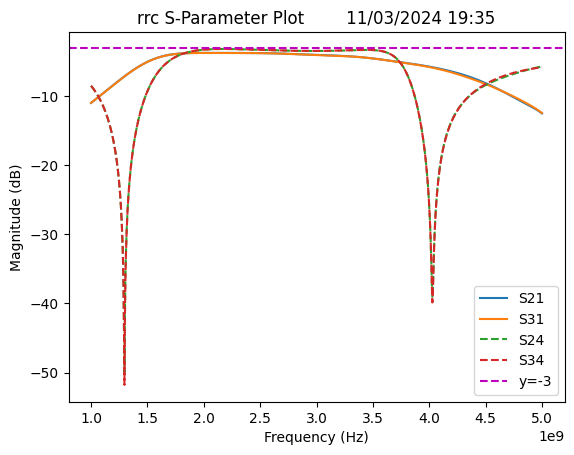

In [16]:
freq_rrc, sparams_rrc = read_s4p('MS_SL_Transition_v32_taper_v2.s4p')
s_plotter(title = 'rrc', which_s='s21 s31 s24 s34', plot_db=True, freq_=freq_rrc, freq_unit='Hz', s_matrix_=sparams_rrc, bw_cutline=-3)

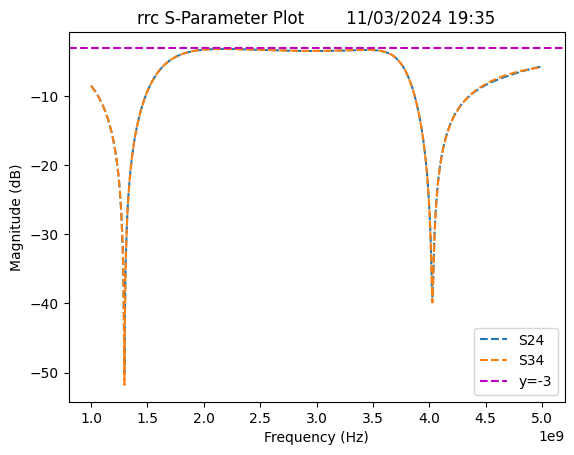

In [17]:
s_plotter(title = 'rrc', which_s='s24 s34', plot_db=True, freq_=freq_rrc, freq_unit='Hz', s_matrix_=sparams_rrc, bw_cutline=-3)

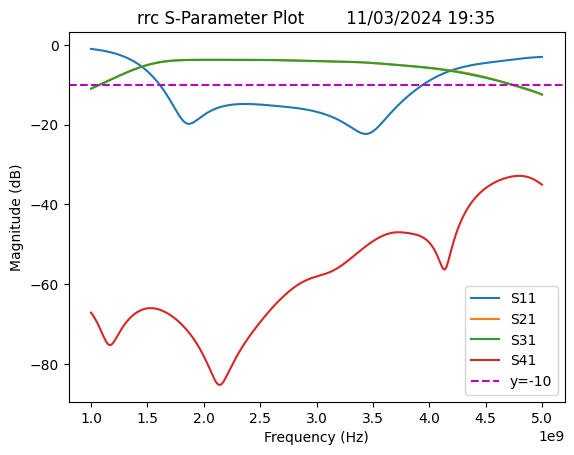

In [18]:
s_plotter(title = 'rrc', which_s='s11s21s31s41', plot_db=True, freq_=freq_rrc, freq_unit='Hz', s_matrix_=sparams_rrc, bw_cutline=-10)

#### Validating rrc with inputs

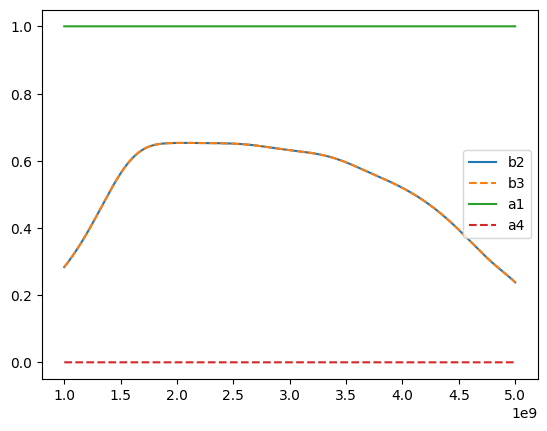

In [19]:
s21_rrc = s_extract(which_s='s21', s_matrix_=sparams_rrc)
s24_rrc = s_extract(which_s='s24', s_matrix_=sparams_rrc)
s31_rrc = s_extract(which_s='s31', s_matrix_=sparams_rrc)
s34_rrc = s_extract(which_s='s34', s_matrix_=sparams_rrc)

a1_rrc = np.array([1 for _ in range(len(s21_rrc))])
a4_rrc = np.array([0 for _ in range(len(s21_rrc))])

b2_amp_rrc = []
b3_amp_rrc = []
b2_phase_rrc = []
b3_phase_rrc = []

# Multiplying input voltage with S params to get the output voltage
for i in range(len(s21_rrc)):
    b2_amp_rrc.append(np.abs((s21_rrc[i]*a1_rrc[i]) + (s24_rrc[i]*a4_rrc[i])))
    b3_amp_rrc.append(np.abs((s34_rrc[i]*a4_rrc[i]) + (s31_rrc[i]*a1_rrc[i])))

    b2_phase_rrc.append(np.angle((s21_rrc[i]*a1_rrc[i]) + (s24_rrc[i]*a4_rrc[i])))
    b3_phase_rrc.append(np.angle((s34_rrc[i]*a4_rrc[i]) + (s31_rrc[i]*a1_rrc[i])))

b2_rrc = np.complex64(np.array(b2_amp_rrc) * np.exp(1j * np.array(b2_phase_rrc)))
b3_rrc = np.complex64(np.array(b3_amp_rrc) * np.exp(1j * np.array(b3_phase_rrc)))

plt.plot(freq_rrc, np.abs(b2_rrc), label = 'b2')
plt.plot(freq_rrc, np.abs(b2_rrc),  linestyle = '--', label = 'b3')
plt.plot(freq_rrc, np.abs(a1_rrc), label = 'a1')
plt.plot(freq_rrc, np.abs(a4_rrc),  linestyle = '--', label = 'a4')
plt.legend()

## Reading Switch

In [20]:
transferswitch_datasheet = '''1000.0 0.04 0.04 92.45 100.96 1.01 1.01 1.01 1.01 120.0
1500.0 0.05 0.05 98.61 87.38 1.01 1.01 1.01 1.01 120.0
2000.0 0.06 0.06 100.79 97.34 1.01 1.02 1.01 1.01 120.0
2500.0 0.07 0.06 97.51 104.72 1.03 1.03 1.03 1.02 120.0
3000.0 0.07 0.07 93.32 102.92 1.05 1.05 1.04 1.04 120.0
3500.0 0.08 0.08 98.46 99.72 1.06 1.07 1.05 1.05 120.0
4000.0 0.08 0.08 95.89 93.03 1.07 1.09 1.06 1.06 120.0
4500.0 0.09 0.09 92.30 99.42 1.07 1.09 1.07 1.07 120.0
5000.0 0.10 0.09 95.75 90.70 1.08 1.10 1.07 1.07 120.0'''

transferswitch_metadata = [[0], [5,1,4,9], [1,6,9,4], [4,9,6,2], [9,4,2,6]]

s params input variable is string, reading...

frequency translated... Length: 9
s params translated... Length: 16

make sure the input s params data is in dB!
Interpolation success :)



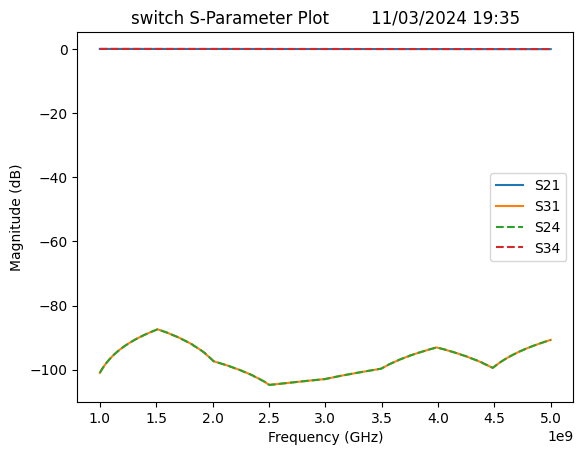

In [21]:
[sparams_switch, _] = interpolate_smatrix_datasheet(ds=transferswitch_datasheet, meta=transferswitch_metadata, db_true=True, db_negate=True, req_length=1030, port=4, lim=[1e9,5e9])

s_plotter(title='switch', which_s='s21 s34 s24 s31', plot_db=True, freq_=freq_rrc, freq_unit='GHz', s_matrix_=sparams_switch, bw_cutline=None)

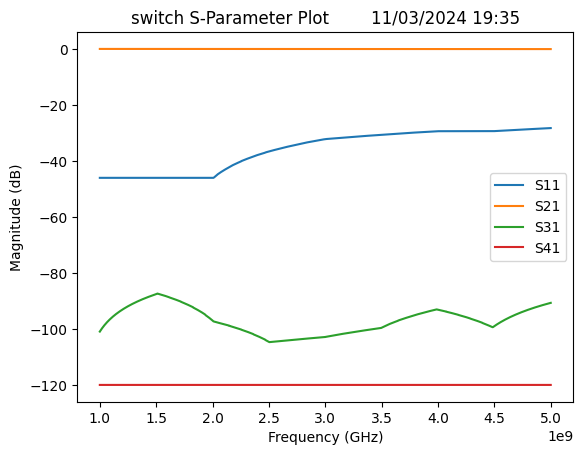

In [22]:
s_plotter(title='switch', which_s='s11s21s31s41', plot_db=True, freq_=freq_rrc, freq_unit='GHz', s_matrix_=sparams_switch, bw_cutline=None)

##### Validation of switch

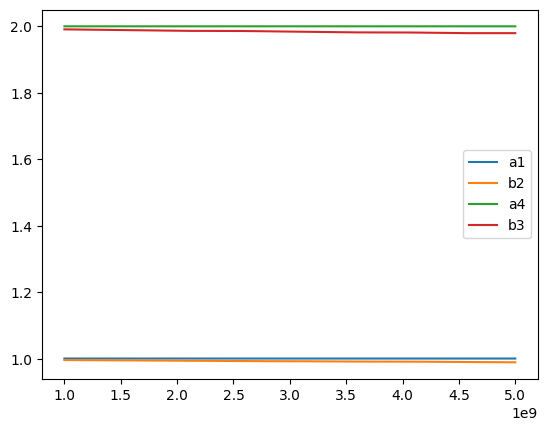

In [23]:
s21_switch = s_extract(which_s='s21', s_matrix_=sparams_switch)
s34_switch = s_extract(which_s='s34', s_matrix_=sparams_switch)
s31_switch = s_extract(which_s='s31', s_matrix_=sparams_switch)
s24_switch = s_extract(which_s='s24', s_matrix_=sparams_switch)

a1_switch = np.array([1 for _ in range(len(s21_switch))])
a4_switch = np.array([2 for _ in range(len(s21_switch))])

b2_amp_switch = []
b3_amp_switch = []
b2_phase_switch = []
b3_phase_switch = []

# Multiplying input voltage with S params to get the output voltage
for i in range(len(s21_switch)):
    b2_amp_switch.append(np.abs((s21_switch[i]*a1_switch[i]) + (s24_switch[i]*a4_switch[i])))
    b3_amp_switch.append(np.abs((s34_switch[i]*a4_switch[i]) + (s31_switch[i]*a1_switch[i])))

    b2_phase_switch.append(np.angle((s21_switch[i]*a1_switch[i]) + (s24_switch[i]*a4_switch[i])))
    b3_phase_switch.append(np.angle((s34_switch[i]*a4_switch[i]) + (s31_switch[i]*a1_switch[i])))

b2_switch = np.complex64(np.array(b2_amp_switch) * np.exp(1j * np.array(b2_phase_switch)))
b3_switch = np.complex64(np.array(b3_amp_switch) * np.exp(1j * np.array(b3_phase_switch)))

plt.plot(freq_rrc, np.abs(a1_switch), label = 'a1')
plt.plot(freq_rrc, np.abs(b2_switch), label = 'b2')
plt.plot(freq_rrc, np.abs(a4_switch), label = 'a4')
plt.plot(freq_rrc, np.abs(b3_switch), label = 'b3')

plt.legend()

## Loading inputs from data

### Antenna Temperature

In [30]:
freq_residues = []
linear_residues = []

with open('residues.txt', 'r') as file:
    lines = file.readlines()
    
    # Check for the correct header
    for line in lines:
        parts = line.split()
        freq_residues.append(float(parts[0])*(1e9))
        linear_residues.append(float(parts[-1]))

In [38]:
def general_line_interpolate(freq_residues, linear_residues, apsera_freq):
    return np.interp(freq_residues, apsera_freq, linear_residues, )

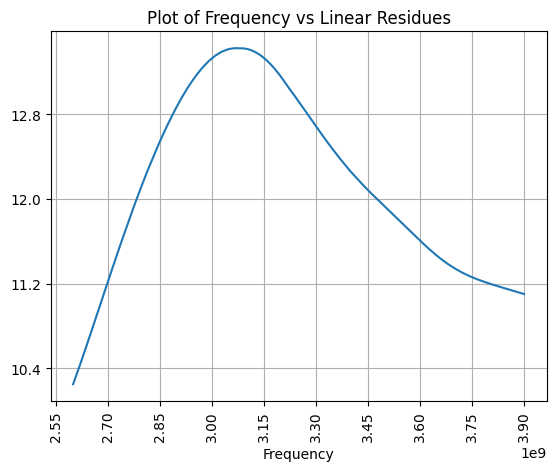

In [39]:
ta_linear_residues = []

apsera_freq = np.linspace(min(freq_residues), max(freq_residues), num=len(freq_residues))  
ta_linear_residues = general_line_interpolate(freq_residues, linear_residues, apsera_freq)

plt.plot(apsera_freq, ta_linear_residues)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))  # For x-axis
plt.gca().yaxis.set_major_locator(MaxNLocator(nbins=5))  # For y-axis, adjust 'nbins' as needed
plt.xticks(rotation=90)

plt.xlabel('Frequency')

plt.title('Plot of Frequency vs Linear Residues')
plt.grid()
plt.show()

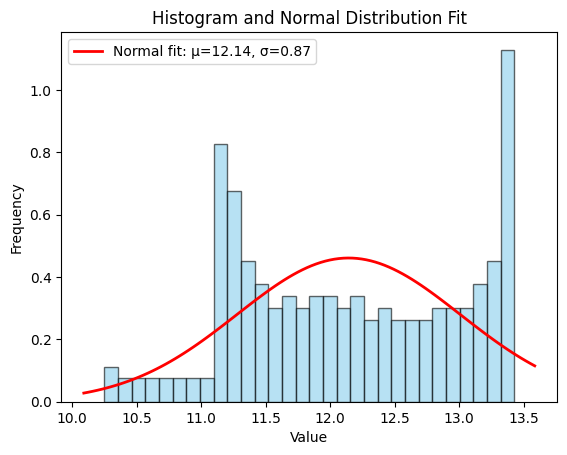

In [302]:
from scipy.stats import norm

# Step 2: Plot the histogram
plt.hist(linear_residues, bins=30, density=True, alpha=0.6, color='skyblue', edgecolor='black')

# Step 3: Fit a normal distribution to the data
# Calculate the mean and standard deviation of your data
mu, std = norm.fit(linear_residues)

# Step 4: Plot the PDF of the fitted distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
pdf = norm.pdf(x, mu, std)
plt.plot(x, pdf, 'r', linewidth=2, label=f'Normal fit: μ={mu:.2f}, σ={std:.2f}')

# Customize and display the plot
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()
plt.title("Histogram and Normal Distribution Fit")
plt.show()

### Converting T_a to Source spectral Flux density

Text(0, 0.5, 'Source Spectral Flux Density (Jy m-2 Hz-1)')

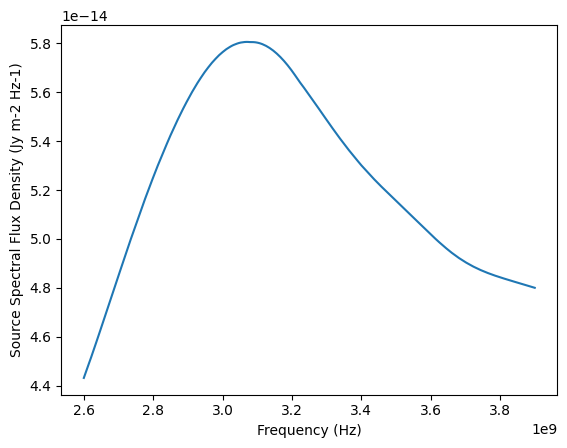

In [232]:
ant_design_wavelength = 3e9
ant_max_gain = -1 #in dB!
s_nu = ((8*np.pi*(1.38e-23))/((ant_design_wavelength**2)*(10**(ant_max_gain/20))))*(ta_linear_residues/1e-26)
plt.plot(freq_residues, s_nu)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Source Spectral Flux Density (Jy m-2 Hz-1)')

### Converting T_a to Voltage

Text(0, 0.5, 'Voltage associated with $T_A$')

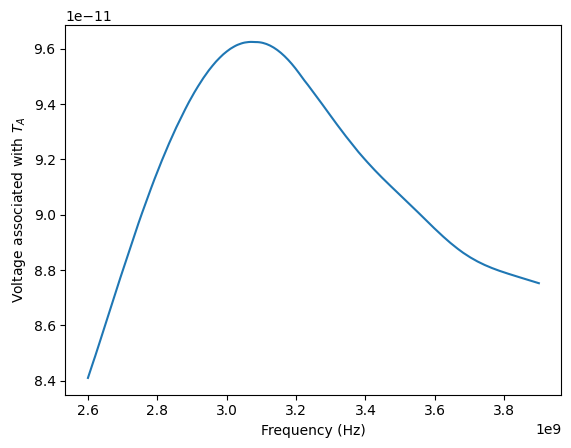

In [272]:
R = 50
V_nu = np.sqrt((1.38e-23)*R*ta_linear_residues)
plt.plot(freq_residues, V_nu)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Voltage associated with $T_A$')

## Getting output treating blocks separately

### Preping RRC

In [32]:
def interpolate_s_matrix_general(s_matrix, current_freq, new_freq):
    """
    Interpolates an S-matrix from current frequency points to new frequency points.
    
    This function takes an S-parameter matrix and interpolates its values from existing
    frequency points to a new set of frequency points using linear interpolation.

    Parameters
    ----------
    s_matrix : numpy.ndarray
        Original S-matrix of shape (m, n, p), where m is the number of frequency points,
        and n and p are the dimensions of the S-parameters (4x4 for a 4-port network
        or 2x2 for a 2-port network).

    current_freq : numpy.ndarray
        Array of current frequency points corresponding to the S-matrix, shape (m,).

    new_freq : numpy.ndarray
        Array of new frequency points for interpolation, shape (k,).

    Returns
    -------
    numpy.ndarray
        Interpolated S-matrix at the new frequency points, shape (k, n, p), where k is
        the number of new frequency points.
    
    Raises
    ------
    ValueError
        If the shape of the input S-matrix is not compatible with the expected dimensions.
    """  
    #m, n, p = s_matrix.shape    
    if s_matrix.shape[1] == 4:
        s11_ = s_extract('s11', s_matrix)
        s12_ = s_extract('s12', s_matrix)
        s13_ = s_extract('s13', s_matrix)
        s14_ = s_extract('s14', s_matrix)
        s21_ = s_extract('s21', s_matrix)
        s22_ = s_extract('s22', s_matrix)
        s23_ = s_extract('s23', s_matrix)
        s24_ = s_extract('s24', s_matrix)
        s31_ = s_extract('s31', s_matrix)
        s32_ = s_extract('s32', s_matrix)
        s33_ = s_extract('s33', s_matrix)
        s34_ = s_extract('s34', s_matrix)
        s41_ = s_extract('s41', s_matrix)
        s42_ = s_extract('s42', s_matrix)
        s43_ = s_extract('s43', s_matrix)
        s44_ = s_extract('s44', s_matrix)
        
        s11_interp = np.interp(new_freq, current_freq, s11_)
        s12_interp = np.interp(new_freq, current_freq, s12_)
        s13_interp = np.interp(new_freq, current_freq, s13_)
        s14_interp = np.interp(new_freq, current_freq, s14_)
        s21_interp = np.interp(new_freq, current_freq, s21_)
        s22_interp = np.interp(new_freq, current_freq, s22_)
        s23_interp = np.interp(new_freq, current_freq, s23_)
        s24_interp = np.interp(new_freq, current_freq, s24_)
        s31_interp = np.interp(new_freq, current_freq, s31_)
        s32_interp = np.interp(new_freq, current_freq, s32_)
        s33_interp = np.interp(new_freq, current_freq, s33_)
        s34_interp = np.interp(new_freq, current_freq, s34_)
        s41_interp = np.interp(new_freq, current_freq, s41_)
        s42_interp = np.interp(new_freq, current_freq, s42_)
        s43_interp = np.interp(new_freq, current_freq, s43_)
        s44_interp = np.interp(new_freq, current_freq, s44_)

        sarray_interp = [s11_interp, s12_interp, s13_interp, s14_interp, s21_interp, s22_interp,s23_interp,s24_interp, s31_interp,s32_interp,s33_interp,s34_interp, s41_interp, s42_interp, s43_interp, s44_interp]

    if s_matrix.shape[1] == 2:
        s11_ = s_extract('s11', s_matrix)
        s12_ = s_extract('s12', s_matrix)
        
        s21_ = s_extract('s21', s_matrix)
        s22_ = s_extract('s22', s_matrix)
        
        
        s11_interp = np.interp(new_freq, current_freq, s11_)
        s12_interp = np.interp(new_freq, current_freq, s12_)
        
        s21_interp = np.interp(new_freq, current_freq, s21_)
        s22_interp = np.interp(new_freq, current_freq, s22_)
        

        sarray_interp = [s11_interp, s12_interp, s21_interp, s22_interp]

    
    Sarray = []

    for i in range(len(sarray_interp[0])):            
        if s_matrix.shape[1] == 4:
            Sarray.append(np.array([[sarray_interp[0][i], sarray_interp[1][i],                    sarray_interp[2][i], sarray_interp[3][i]],
                                    [sarray_interp[4][i], sarray_interp[5][i], sarray_interp[6][i], sarray_interp[7][i]],
                                    [sarray_interp[8][i], sarray_interp[9][i], sarray_interp[10][i],sarray_interp[11][i]],
                                    [sarray_interp[12][i],sarray_interp[13][i],sarray_interp[14][i],sarray_interp[15][i]] ]))
        elif s_matrix.shape[1] == 2:
            Sarray.append(np.array([ [sarray_interp[0][i], sarray_interp[1][i]] ,
                                        [sarray_interp[2][i], sarray_interp[3][i]] ]))
    return np.array(Sarray)

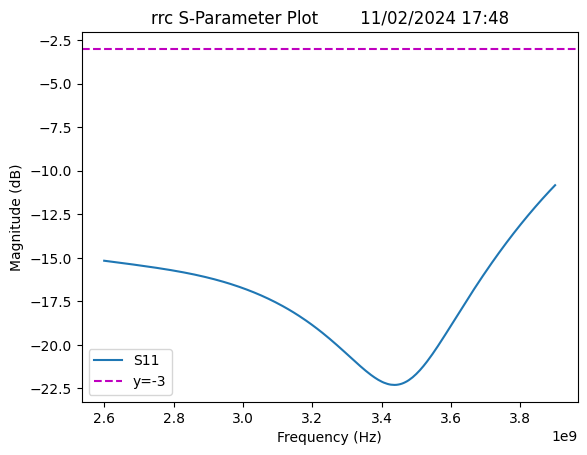

In [274]:
rrc = interpolate_s_matrix_general(sparams_rrc, freq_rrc, apsera_freq)
s_plotter(title = 'rrc', which_s='s11', plot_db=True, freq_=apsera_freq, freq_unit='Hz', s_matrix_=rrc, bw_cutline=-3)

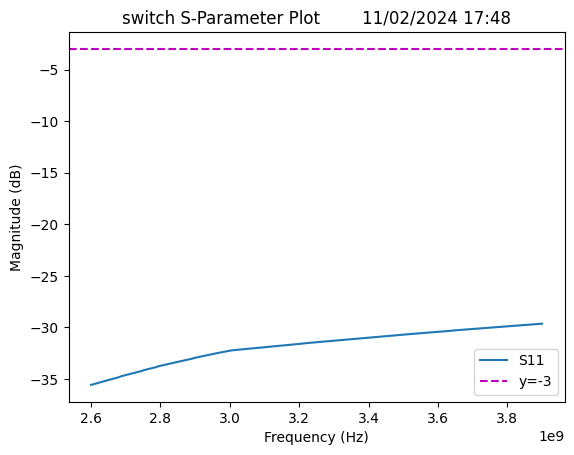

In [275]:
switch = interpolate_s_matrix_general(sparams_switch, freq_rrc, apsera_freq)
s_plotter(title = 'switch', which_s='s11', plot_db=True, freq_=apsera_freq, freq_unit='Hz', s_matrix_=switch, bw_cutline=-3)

### First stage

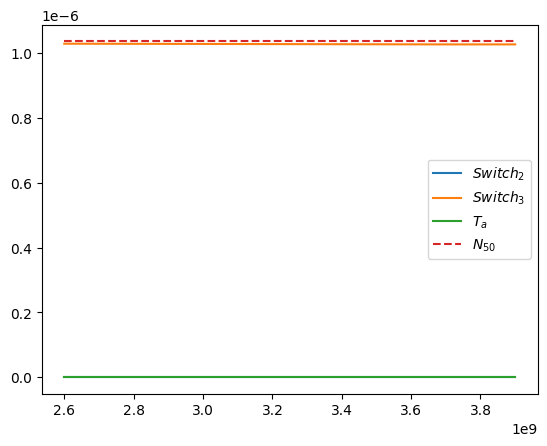

In [306]:
s21_switch = s_extract(which_s='s21', s_matrix_=switch)
s34_switch = s_extract(which_s='s34', s_matrix_=switch)
s31_switch = s_extract(which_s='s31', s_matrix_=switch)
s24_switch = s_extract(which_s='s24', s_matrix_=switch)

freq_res = ((max(apsera_freq) - min(apsera_freq))/len(apsera_freq))

a1_switch = V_nu
a4_switch = noise_50(t = 300, b=freq_res, length=len(s21_switch))

b2_amp_switch = []
b3_amp_switch = []
b2_phase_switch = []
b3_phase_switch = []

# Multiplying input voltage with S params to get the output voltage
for i in range(len(s21_switch)):
    b2_amp_switch.append(np.abs((s21_switch[i]*a1_switch[i]) + (s24_switch[i]*a4_switch[i])))
    b3_amp_switch.append(np.abs((s34_switch[i]*a4_switch[i]) + (s31_switch[i]*a1_switch[i])))

    b2_phase_switch.append(np.angle((s21_switch[i]*a1_switch[i]) + (s24_switch[i]*a4_switch[i])))
    b3_phase_switch.append(np.angle((s34_switch[i]*a4_switch[i]) + (s31_switch[i]*a1_switch[i])))

b2_switch = np.complex64(np.array(b2_amp_switch) * np.exp(1j * np.array(b2_phase_switch)))
b3_switch = np.complex64(np.array(b3_amp_switch) * np.exp(1j * np.array(b3_phase_switch)))

plt.plot(apsera_freq, np.abs(b2_switch), label = '$Switch_{2}$')
plt.plot(apsera_freq, np.abs(b3_switch), label = '$Switch_{3}$')
plt.plot(apsera_freq, np.abs(a1_switch), label = '$T_{a}$')
plt.plot(apsera_freq, np.abs(a4_switch), linestyle='--', label = '$N_{50}$')
plt.legend()

### Second stage

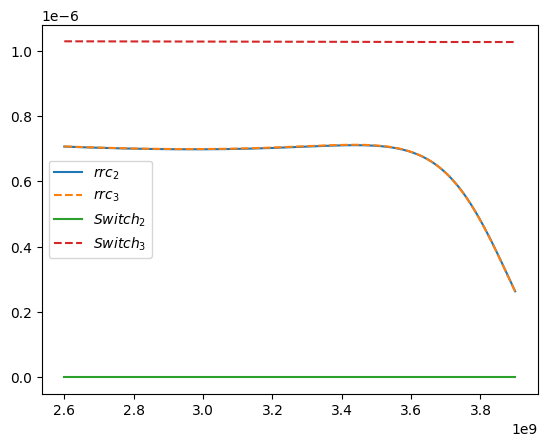

In [307]:
s21_rrc = s_extract(which_s='s21', s_matrix_=rrc)
s34_rrc = s_extract(which_s='s34', s_matrix_=rrc)
s31_rrc = s_extract(which_s='s31', s_matrix_=rrc)
s24_rrc = s_extract(which_s='s24', s_matrix_=rrc)

freq_res = ((max(apsera_freq) - min(apsera_freq))/len(apsera_freq))

a1_rrc = b2_switch
a4_rrc = b3_switch

b2_amp_rrc = []
b3_amp_rrc = []
b2_phase_rrc = []
b3_phase_rrc = []

# Multiplying input voltage with S params to get the output voltage
for i in range(len(s21_switch)):
    b2_amp_rrc.append(np.abs((s21_rrc[i]*a1_switch[i]) + (s24_rrc[i]*a4_switch[i])))
    b3_amp_rrc.append(np.abs((s34_rrc[i]*a4_switch[i]) + (s31_rrc[i]*a1_switch[i])))

    b2_phase_rrc.append(np.angle((s21_rrc[i]*a1_switch[i]) + (s24_rrc[i]*a4_switch[i])))
    b3_phase_rrc.append(np.angle((s34_rrc[i]*a4_switch[i]) + (s31_rrc[i]*a1_switch[i])))

b2_rrc = np.complex64(np.array(b2_amp_rrc) * np.exp(1j * np.array(b2_phase_rrc)))
b3_rrc = np.complex64(np.array(b3_amp_rrc) * np.exp(1j * np.array(b3_phase_rrc)))

plt.plot(apsera_freq, np.abs(b2_rrc), label = '$rrc_{2}$')
plt.plot(apsera_freq, np.abs(b3_rrc), linestyle='--', label = '$rrc_{3}$')
plt.plot(apsera_freq, np.abs(a1_rrc), label = '$Switch_{2}$')
plt.plot(apsera_freq, np.abs(a4_rrc), linestyle='--', label = '$Switch_{3}$')
plt.legend()

### Preping amplifier

File format accepted, reading...
Frequency data in Hz
Frequency and S-matrix created


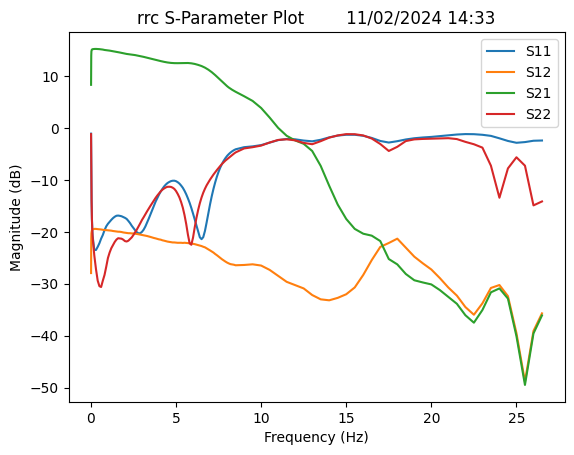

In [236]:
freq_amp, sparams_amp = read_s2p('PHA-83W+_5.00V_Plus25DegC_TB-PHA-83WE+.s2p')

s_plotter(title = 'rrc', which_s='s11 s21 s12 s22', plot_db=True, freq_=freq_amp/1e9, freq_unit='Hz', s_matrix_=sparams_amp, bw_cutline=None)

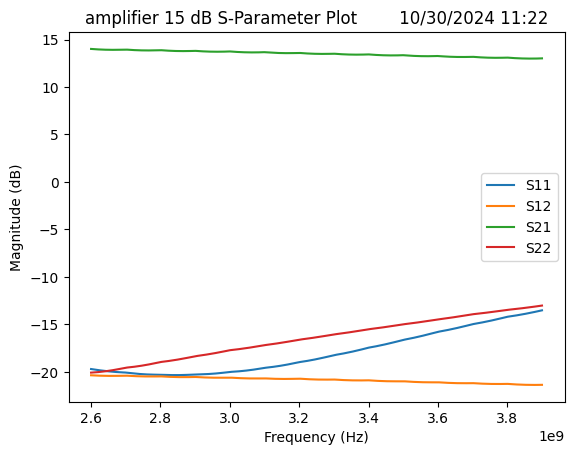

In [145]:
amp = interpolate_s_matrix_general(sparams_amp, freq_amp, apsera_freq)

s_plotter(title = 'amplifier 15 dB', which_s='s11 s12 s21 s22', plot_db=True, freq_=apsera_freq, freq_unit='Hz', s_matrix_=amp, bw_cutline=None)

In [314]:
def general_interpolate(freq_ds,sarray_db,lim, req_length, port):
    if port == 2:    

        s11_ = s_extract('s11', sarray_db)
        s12_ = s_extract('s12', sarray_db)
        s21_ = s_extract('s21', sarray_db)
        s22_ = s_extract('s22', sarray_db)
        sarray_db = [s11_,s12_,s21_,s22_]
        
        sarray_db_interp = []        
        for i in sarray_db:
            new_indices = np.linspace(lim[0], lim[1], num=int(req_length))  
            
            # Cubic spline interpolation
            cubic_interpolator = CubicSpline(freq_ds, i)
            sarray_db_interp.append(cubic_interpolator(new_indices))
    else: 
        ValueError('4 port s matrix not supported yet')
    
    # interpolater

    print('Interpolation success :)')
    print("========================================================\n") 

    Sarray = []
    for i in range(len(sarray_db_interp[0])):     
              
        if port == 4:
            Sarray.append(np.array([[sarray_db_interp[0][i], sarray_db_interp[1][i], sarray_db_interp[2][i], sarray_db_interp[3][i]],
                                    [sarray_db_interp[4][i], sarray_db_interp[5][i], sarray_db_interp[6][i], sarray_db_interp[7][i]],
                                    [sarray_db_interp[8][i], sarray_db_interp[9][i], sarray_db_interp[10][i],sarray_db_interp[11][i]],
                                    [sarray_db_interp[12][i],sarray_db_interp[13][i],sarray_db_interp[14][i],sarray_db_interp[15][i]] ]))
        elif port == 2:
            Sarray.append(np.array([ [sarray_db_interp[0][i], sarray_db_interp[1][i]] ,
                                        [sarray_db_interp[2][i], sarray_db_interp[3][i]] ]))
    return [np.array(Sarray), new_indices]   

### Multiplying amplifier gain to outputs

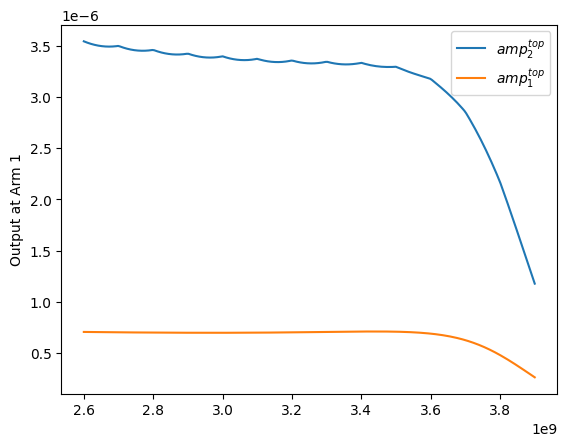

In [308]:
a1_amp = b2_rrc
s21_amp = s_extract('s21', amp)

b2_amp_amp = []
b2_phase_amp = []

# Multiplying input voltage with S params to get the output voltage
for i in range(len(s21_amp)):
    b2_amp_amp.append(np.abs(s21_amp[i]*a1_amp[i]))
    b2_phase_amp.append(np.angle(s21_amp[i]*a1_amp[i]))

b2_amp_top = np.complex64(np.array(b2_amp_amp) * np.exp(1j * np.array(b2_phase_amp)))

plt.plot(apsera_freq, np.abs(b2_amp_top), label = '$amp_{2}^{top}$')
plt.plot(apsera_freq, np.abs(a1_amp), label = '$amp_{1}^{top}$')
plt.ylabel('Output at Arm 1')
plt.legend()

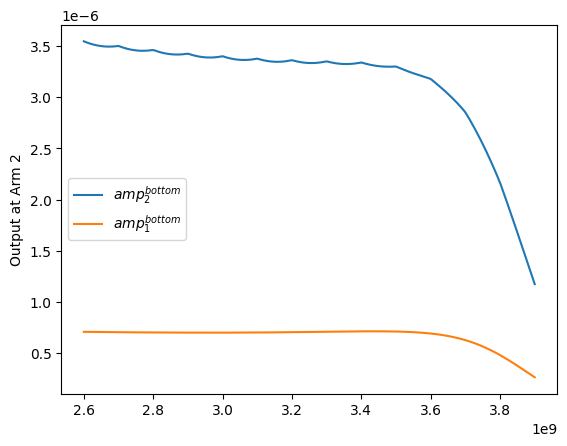

In [309]:
a1_amp_low = b3_rrc
s21_amp = s_extract('s21', amp)

b2_amp_amp_low = []
b2_phase_amp_low = []

# Multiplying input voltage with S params to get the output voltage
for i in range(len(s21_amp)):
    b2_amp_amp_low.append(np.abs(s21_amp[i]*a1_amp_low[i]))
    b2_phase_amp_low.append(np.angle(s21_amp[i]*a1_amp_low[i]))

b2_amp_bottom = np.complex64(np.array(b2_amp_amp_low) * np.exp(1j * np.array(b2_phase_amp_low)))

plt.plot(apsera_freq, np.abs(b2_amp_bottom), label = '$amp_{2}^{bottom}$')
plt.plot(apsera_freq, np.abs(a1_amp_low), label = '$amp_{1}^{bottom}$')
plt.ylabel('Output at Arm 2')
plt.legend()

### Correlation

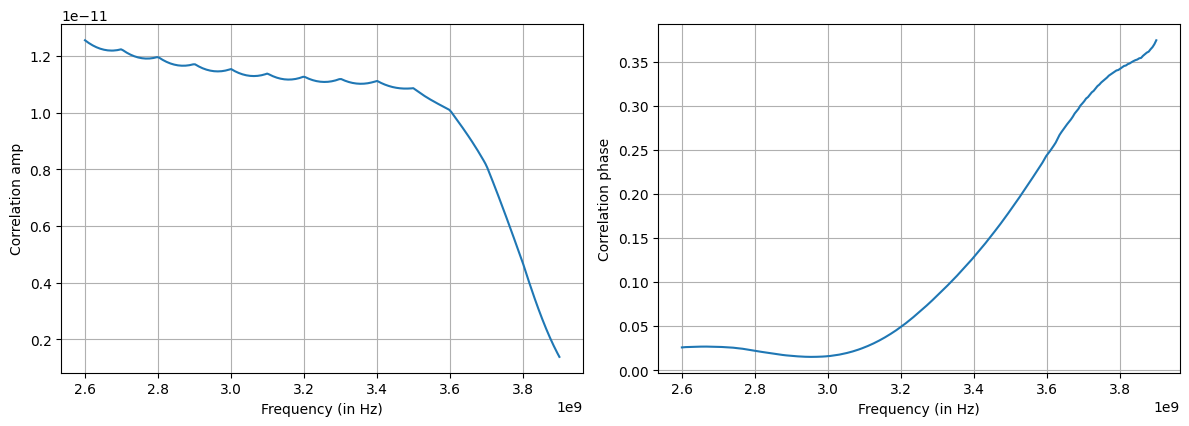

In [ ]:
cross_correlation_out = b2_amp_top * np.conj(b2_amp_bottom)

# Create 2x2 subplots
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(apsera_freq, np.abs(cross_correlation_out), label = ' corr signal amp')
plt.ylabel('Correlation amp')
plt.xlabel('Frequency (in Hz)')
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(apsera_freq ,np.unwrap(np.degrees(np.angle(cross_correlation_out))), label = 'corr signal phase')
plt.ylabel('Correlation phase')
plt.xlabel('Frequency (in Hz)')
plt.legend
plt.grid()


plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

## Ideal scenario

In [ ]:
import cmath

def ideal_switch_gen(freq_):
   """
    Generates an ideal switch S-parameter matrix in complex form.

    This function creates an S-parameter matrix for a 4-port ideal switch 
    based on given frequency points. The S-parameters are expressed in dB.

    Parameters
    ----------
    freq_ : list or numpy.ndarray
        Frequency points (in Hz) at which the S-parameters are calculated. 
        The length of this array determines the number of frequency points 
        in the generated S-parameter matrix.

    Returns
    -------
    numpy.ndarray
        A 3D array containing the S-parameter matrices for each frequency point,
        shape (len(freq_), 4, 4).

    Example
    -------
    >>> freq_points = np.array([1e9, 2e9, 3e9])  # Frequency points in Hz
    >>> s_matrix = ideal_switch_gen(freq_points)
    """
   val1 = 10**(-120/20)
   val2 = 1
   
   s11_ = [cmath.rect(val1, math.radians(0))]*len(freq_)
   s12_ = [cmath.rect(val2, math.radians(90))]*len(freq_)
   s13_ = [cmath.rect(val1, math.radians(180))]*len(freq_)
   s14_ = [cmath.rect(val1, math.radians(90))]*len(freq_)

   s21_ = [cmath.rect(val2, math.radians(90))]*len(freq_)
   s22_ = [cmath.rect(val1, math.radians(0))]*len(freq_)
   s23_ = [cmath.rect(val1, math.radians(90))]*len(freq_)
   s24_ = [cmath.rect(val1, math.radians(180))]*len(freq_)

   s31_ = [cmath.rect(val1, math.radians(180))]*len(freq_)
   s32_ = [cmath.rect(val1, math.radians(90))]*len(freq_)
   s33_ = [cmath.rect(val1, math.radians(0))]*len(freq_)
   s34_ = [cmath.rect(val2, math.radians(90))]*len(freq_)

   s41_ = [cmath.rect(val1, math.radians(90))]*len(freq_)
   s42_ = [cmath.rect(val1, math.radians(180))]*len(freq_)
   s43_ = [cmath.rect(val2, math.radians(90))]*len(freq_)
   s44_ = [cmath.rect(val1, math.radians(0))]*len(freq_)

   sarray_interp = [s11_, s12_, s13_, s14_, s21_, s22_,s23_,s24_, s31_,s32_,s33_,s34_, s41_, s42_, s43_, s44_]

   Sarray = []
   for i in range(len(freq_)):
      Sarray.append(np.array([[sarray_interp[0][i], sarray_interp[1][i],                    sarray_interp[2][i], sarray_interp[3][i]],
                              [sarray_interp[4][i], sarray_interp[5][i], sarray_interp[6][i], sarray_interp[7][i]],
                              [sarray_interp[8][i], sarray_interp[9][i], sarray_interp[10][i],sarray_interp[11][i]],
                              [sarray_interp[12][i],sarray_interp[13][i],sarray_interp[14][i],sarray_interp[15][i]] ]))

   return np.array(Sarray)   

In [ ]:
def ideal_rrc_gen(freq_):
   """
    Generates an ideal rat race coupler (RRC) S-parameter matrix in complex form.

    This function creates an S-parameter matrix for a 4-port ideal rat race coupler
    filter based on given frequency points. The S-parameters are expressed in complex 
    values representing the filter characteristics.

    Parameters
    ----------
    freq_ : list or numpy.ndarray
        Frequency points (in Hz) at which the S-parameters are calculated. 
        The length of this array determines the number of frequency points 
        in the generated S-parameter matrix.

    Returns
    -------
    numpy.ndarray
        A 3D array containing the S-parameter matrices for each frequency point,
        shape (len(freq_), 4, 4).

    Example
    -------
    >>> freq_points = np.array([1e9, 2e9, 3e9])  # Frequency points in Hz
    >>> s_matrix = ideal_rrc_gen(freq_points)
    """
   
   s11_ = [0.000001]*len(freq_)
   s12_ = [0-0.707j]*len(freq_)
   s13_ = [0.000001]*len(freq_)
   s14_ = [0+0.707j]*len(freq_)

   s21_ = [0-0.707j]*len(freq_)
   s22_ = [0.000001]*len(freq_)
   s23_ = [0-0.707j]*len(freq_)
   s24_ = [0.000001]*len(freq_)

   s31_ = [0.000001]*len(freq_)
   s32_ = [0-0.707j]*len(freq_)
   s33_ = [0.000001]*len(freq_)
   s34_ = [0-0.707j]*len(freq_)

   s41_ = [0+0.707j]*len(freq_)
   s42_ = [0.000001]*len(freq_)
   s43_ = [0-0.707j]*len(freq_)
   s44_ = [0.000001]*len(freq_)

   sarray_interp = [s11_, s12_, s13_, s14_, s21_, s22_,s23_,s24_, s31_,s32_,s33_,s34_, s41_, s42_, s43_, s44_]

   Sarray = []
   for i in range(len(freq_)):
      Sarray.append(np.array([[sarray_interp[0][i], sarray_interp[1][i],                    sarray_interp[2][i], sarray_interp[3][i]],
                              [sarray_interp[4][i], sarray_interp[5][i], sarray_interp[6][i], sarray_interp[7][i]],
                              [sarray_interp[8][i], sarray_interp[9][i], sarray_interp[10][i],sarray_interp[11][i]],
                              [sarray_interp[12][i],sarray_interp[13][i],sarray_interp[14][i],sarray_interp[15][i]] ]))

   return np.array(Sarray)   

In [343]:
def ideal_amp_gen(freq_):
   '''Makes an ideal amplifier S matrix
      in dB!'''
   
   s11_ = [0.000001]*len(freq_)
   s12_ = [cmath.rect(5.623413251903491, math.radians(90))]*len(freq_)
   
   s21_ = [cmath.rect(5.623413251903491, math.radians(90))]*len(freq_)
   s22_ = [0.000001]*len(freq_)
   
   sarray_interp = [s11_, s12_, s21_, s22_]

   Sarray = []
   for i in range(len(freq_)):
      Sarray.append(np.array([[sarray_interp[0][i], sarray_interp[1][i]] ,
                              [sarray_interp[2][i], sarray_interp[3][i]] ]))

   return np.array(Sarray)   

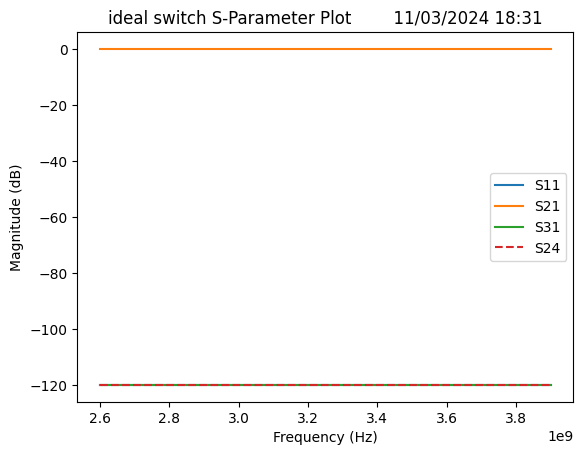

In [344]:
switch_ideal = ideal_switch_gen(apsera_freq)
s_plotter(title = 'ideal switch', which_s='s11s21s31s24', plot_db=True, freq_=apsera_freq, freq_unit='Hz', s_matrix_=switch_ideal, bw_cutline=None)

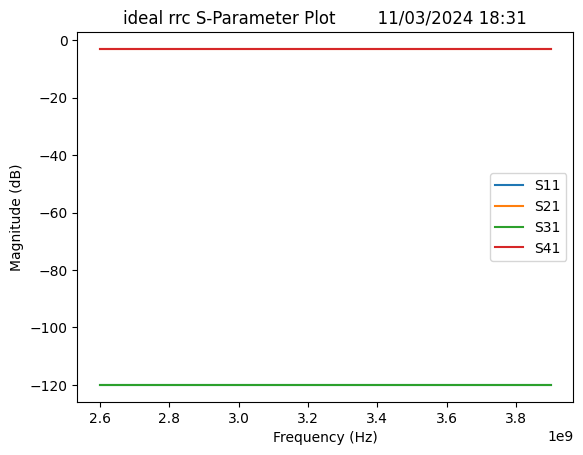

In [345]:
rrc_ideal = ideal_rrc_gen(apsera_freq)
s_plotter(title = 'ideal rrc', which_s='s11s41s21s31', plot_db=True, freq_=apsera_freq, freq_unit='Hz', s_matrix_=rrc_ideal, bw_cutline=None)

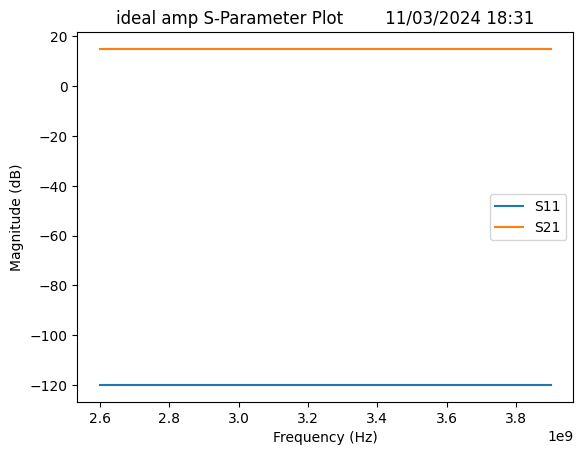

In [346]:
amp_ideal = ideal_amp_gen(apsera_freq)
s_plotter(title = 'ideal amp', which_s='s11s21', plot_db=True, freq_=apsera_freq, freq_unit='Hz', s_matrix_=amp_ideal, bw_cutline=None)

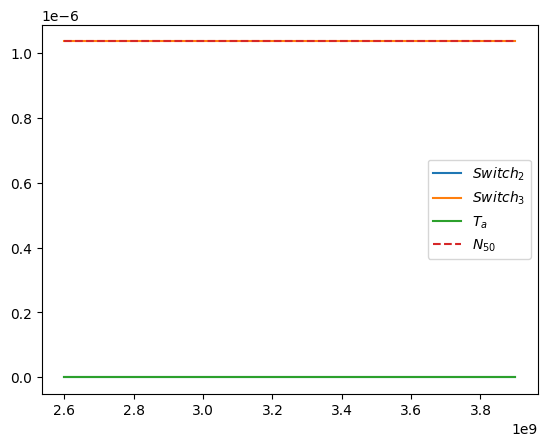

In [347]:
s21_switch = s_extract(which_s='s21', s_matrix_=switch_ideal)
s34_switch = s_extract(which_s='s34', s_matrix_=switch_ideal)
s31_switch = s_extract(which_s='s31', s_matrix_=switch_ideal)
s24_switch = s_extract(which_s='s24', s_matrix_=switch_ideal)

freq_res = ((max(apsera_freq) - min(apsera_freq))/len(apsera_freq))

a1_switch = V_nu
a4_switch = noise_50(t = 300, b=freq_res, length=len(s21_switch))

b2_amp_switch = []
b3_amp_switch = []
b2_phase_switch = []
b3_phase_switch = []

# Multiplying input voltage with S params to get the output voltage
for i in range(len(s21_switch)):
    b2_amp_switch.append(np.abs((s21_switch[i]*a1_switch[i]) + (s24_switch[i]*a4_switch[i])))
    b3_amp_switch.append(np.abs((s34_switch[i]*a4_switch[i]) + (s31_switch[i]*a1_switch[i])))

    b2_phase_switch.append(np.angle((s21_switch[i]*a1_switch[i]) + (s24_switch[i]*a4_switch[i])))
    b3_phase_switch.append(np.angle((s34_switch[i]*a4_switch[i]) + (s31_switch[i]*a1_switch[i])))

b2_switch = np.complex64(np.array(b2_amp_switch) * np.exp(1j * np.array(b2_phase_switch)))
b3_switch = np.complex64(np.array(b3_amp_switch) * np.exp(1j * np.array(b3_phase_switch)))

plt.plot(apsera_freq, np.abs(b2_switch), label = '$Switch_{2}$')
plt.plot(apsera_freq, np.abs(b3_switch), label = '$Switch_{3}$')
plt.plot(apsera_freq, np.abs(a1_switch), label = '$T_{a}$')
plt.plot(apsera_freq, np.abs(a4_switch), linestyle='--', label = '$N_{50}$')
plt.legend()

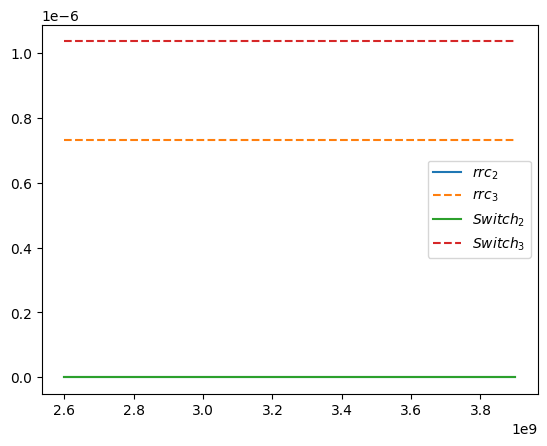

In [348]:
s21_rrc = s_extract(which_s='s21', s_matrix_=rrc_ideal)
s34_rrc = s_extract(which_s='s34', s_matrix_=rrc_ideal)
s31_rrc = s_extract(which_s='s31', s_matrix_=rrc_ideal)
s24_rrc = s_extract(which_s='s24', s_matrix_=rrc_ideal)

freq_res = ((max(apsera_freq) - min(apsera_freq))/len(apsera_freq))

a1_rrc = b2_switch
a4_rrc = b3_switch

b2_amp_rrc = []
b3_amp_rrc = []
b2_phase_rrc = []
b3_phase_rrc = []

# Multiplying input voltage with S params to get the output voltage
for i in range(len(s21_switch)):
    b2_amp_rrc.append(np.abs((s21_rrc[i]*a1_switch[i]) + (s24_rrc[i]*a4_switch[i])))
    b3_amp_rrc.append(np.abs((s34_rrc[i]*a4_switch[i]) + (s31_rrc[i]*a1_switch[i])))

    b2_phase_rrc.append(np.angle((s21_rrc[i]*a1_switch[i]) + (s24_rrc[i]*a4_switch[i])))
    b3_phase_rrc.append(np.angle((s34_rrc[i]*a4_switch[i]) + (s31_rrc[i]*a1_switch[i])))

b2_rrc = np.complex64(np.array(b2_amp_rrc) * np.exp(1j * np.array(b2_phase_rrc)))
b3_rrc = np.complex64(np.array(b3_amp_rrc) * np.exp(1j * np.array(b3_phase_rrc)))

plt.plot(apsera_freq, np.abs(b2_rrc), label = '$rrc_{2}$')
plt.plot(apsera_freq, np.abs(b3_rrc), linestyle='--', label = '$rrc_{3}$')
plt.plot(apsera_freq, np.abs(a1_rrc), label = '$Switch_{2}$')
plt.plot(apsera_freq, np.abs(a4_rrc), linestyle='--', label = '$Switch_{3}$')
plt.legend()

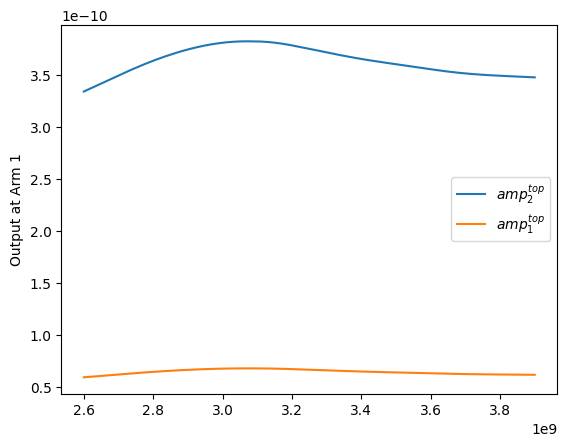

In [349]:
a1_amp = b2_rrc
s21_amp = s_extract('s21', amp_ideal)

b2_amp_amp = []
b2_phase_amp = []

# Multiplying input voltage with S params to get the output voltage
for i in range(len(s21_amp)):
    b2_amp_amp.append(np.abs(s21_amp[i]*a1_amp[i]))
    b2_phase_amp.append(np.angle(s21_amp[i]*a1_amp[i]))

b2_amp_top = np.complex64(np.array(b2_amp_amp) * np.exp(1j * np.array(b2_phase_amp)))

plt.plot(apsera_freq, np.abs(b2_amp_top), label = '$amp_{2}^{top}$')
plt.plot(apsera_freq, np.abs(a1_amp), label = '$amp_{1}^{top}$')
plt.ylabel('Output at Arm 1')
plt.legend()

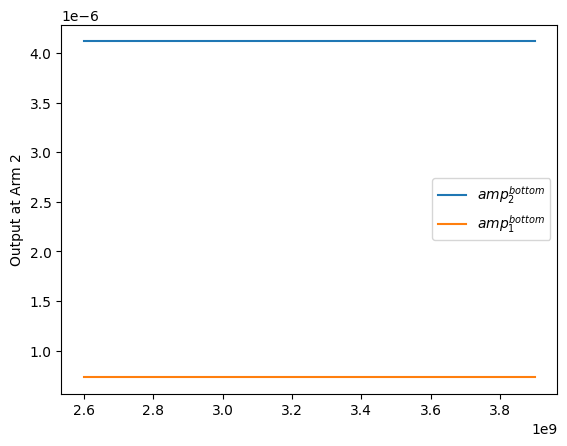

In [350]:
a1_amp_low = b3_rrc
s21_amp = s_extract('s21', amp_ideal)

b2_amp_amp_low = []
b2_phase_amp_low = []

# Multiplying input voltage with S params to get the output voltage
for i in range(len(s21_amp)):
    b2_amp_amp_low.append(np.abs(s21_amp[i]*a1_amp_low[i]))
    b2_phase_amp_low.append(np.angle(s21_amp[i]*a1_amp_low[i]))

b2_amp_bottom = np.complex64(np.array(b2_amp_amp_low) * np.exp(1j * np.array(b2_phase_amp_low)))

plt.plot(apsera_freq, np.abs(b2_amp_bottom), label = '$amp_{2}^{bottom}$')
plt.plot(apsera_freq, np.abs(a1_amp_low), label = '$amp_{1}^{bottom}$')
plt.ylabel('Output at Arm 2')
plt.legend()

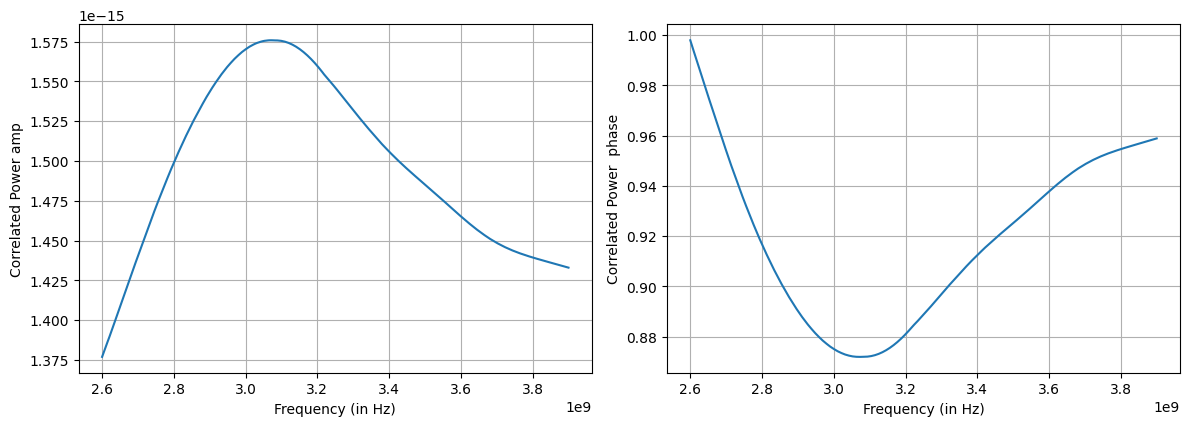

In [ ]:
cross_correlation_out = b2_amp_top * np.conj(b2_amp_bottom)

# Create 2x2 subplots
plt.figure(figsize=(12, 8))

# plt.subplot(2, 2, 1)
# plt.plot(apsera_freq, cross_correlation_out, label = 'correlated signal')
# plt.ylabel('Correlation complex')
# plt.xlabel('Frequency (in Hz)')
# plt.grid()

plt.subplot(2, 2, 1)
plt.plot(apsera_freq, np.abs(cross_correlation_out), label = 'corr signal amp')
plt.ylabel('Correlated Power amp')
plt.xlabel('Frequency (in Hz)')
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(apsera_freq ,np.unwrap(np.degrees(np.angle(cross_correlation_out))), label = 'corr signal phase')
plt.ylabel('Correlated Power  phase')
plt.xlabel('Frequency (in Hz)')
plt.legend
plt.grid()

# plt.subplot(2, 2, 4)
# plt.scatter(apsera_freq, np.real(cross_correlation_out), np.imag(cross_correlation_out))
# plt.xlabel('Real')
# plt.ylabel('Imag')
# plt.grid()

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

## Cascading rrc + switch 

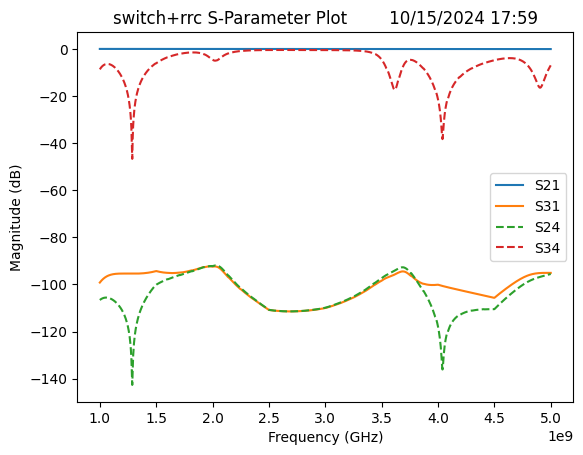

In [30]:
sparams_switch_rrc = matrix_cascader_manual(sparams_switch, sparams_rrc)
s_plotter(title='switch+rrc', which_s=' s21 s34 s24 s31', plot_db=True, freq_=freq_rrc, freq_unit='GHz', s_matrix_=sparams_switch_rrc, bw_cutline=None)

## Saving as rrc and switch as s4p file

In [31]:
save_s4p('switch.s4p', sparams_switch, freq_rrc)

#save_s4p('rrc.s4p', sparams_rrc, freq_rrc)

## Extract voltage from ports 2 and 3 for block rrc+switch

#### Extract s params, i/p, o/p voltage

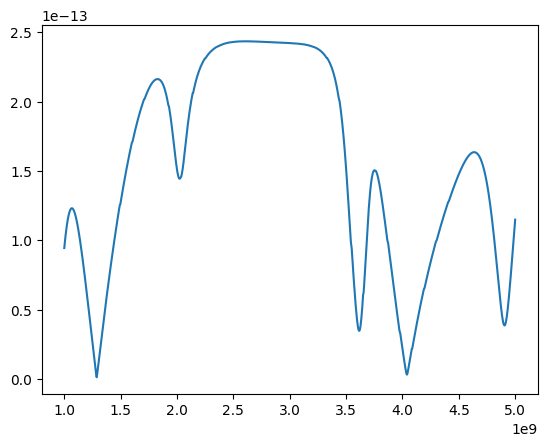

In [32]:
# S extracted ======================
s21_cascade = list(s_extract(which_s='s21', s_matrix_=sparams_switch_rrc))
s34_cascade = list(s_extract(which_s='s34', s_matrix_=sparams_switch_rrc))

# Specify input voltages and get output voltages =======================
b2_amp = []
b3_amp = []
b2_phase = []
b3_phase = []

#input voltage
a1 = np.array([1 for _ in range(len(s21_cascade))])
a4 = noise_50(t = 300, b=4e9, length=len(s21_cascade))

# Multiplying input voltage with S params to get the output voltage
for i in range(len(s21_cascade)):
    b2_amp.append(np.abs(s21_cascade[i] * a1[i]))
    b3_amp.append(np.abs(s34_cascade[i] * a4[i]))

    b2_phase.append(np.angle(s21_cascade[i] * a1[i]))
    b3_phase.append(np.angle(s34_cascade[i] * a4[i]))

b2_amp = np.array(b2_amp)
b2_phase = np.array(b2_phase)
b3_amp = np.array(b3_amp)
b3_phase = np.array(b3_phase)

b2 = np.complex64(b2_amp * np.exp(1j * b2_phase))
b3 = np.complex64(b3_amp * np.exp(1j * b3_phase))

plt.plot(freq_rrc, b3_amp)

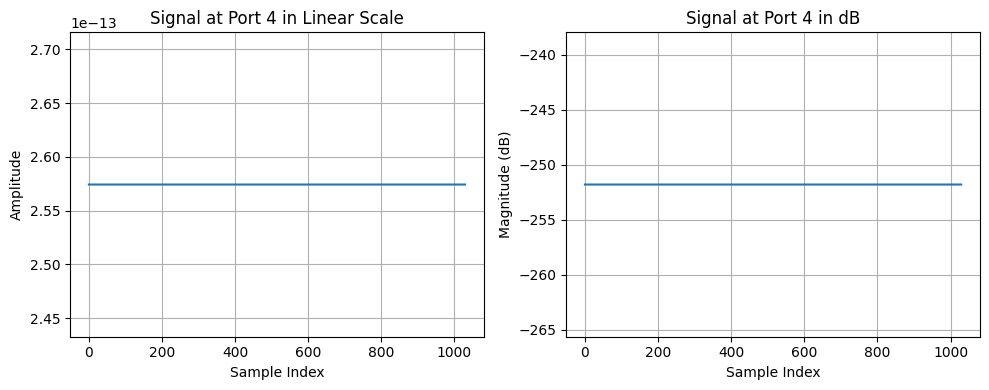

In [37]:
# Create a figure and two subplots
fig, (plt1, plt2) = plt.subplots(1, 2, figsize=(10, 4))

# Plot in linear scale
plt1.plot(a4)
plt1.set_title('Signal at Port 4 in Linear Scale')
plt1.set_xlabel('Sample Index')  # Optionally add x-axis label
plt1.set_ylabel('Amplitude')      # Optionally add y-axis label
plt1.grid()                       # Optionally add grid

# Plot in dB
plt2.plot(20 * np.log10(np.abs(a4)))  # Ensure you're using the absolute value if a4 has complex numbers
plt2.set_title('Signal at Port 4 in dB')
plt2.set_xlabel('Sample Index')  # Optionally add x-axis label
plt2.set_ylabel('Magnitude (dB)')  # Optionally add y-axis label
plt2.grid()                       # Optionally add grid

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Signal at port 4 in dB')

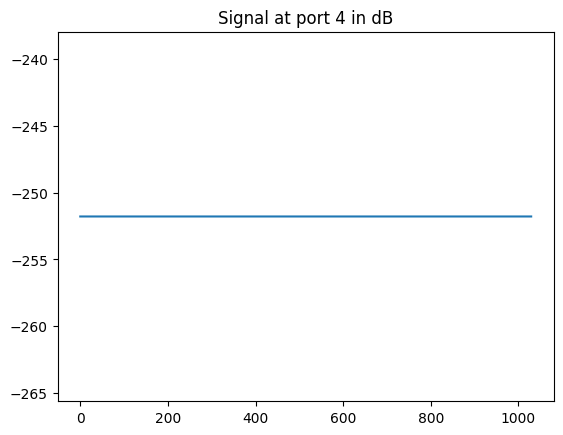

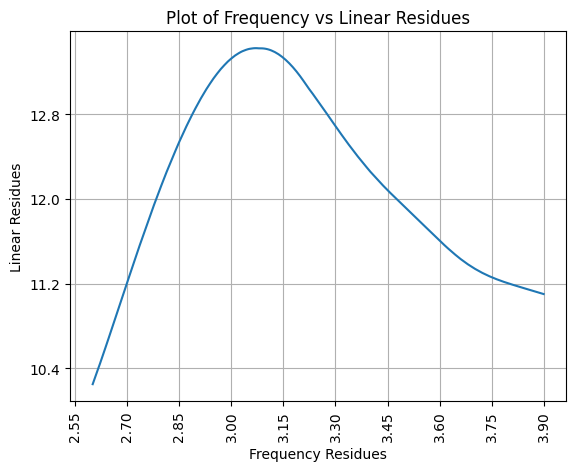

### Plot i/p & o/p voltages (amp+phase) 

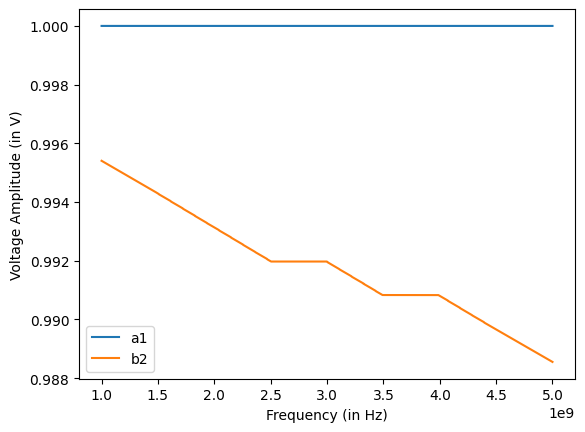

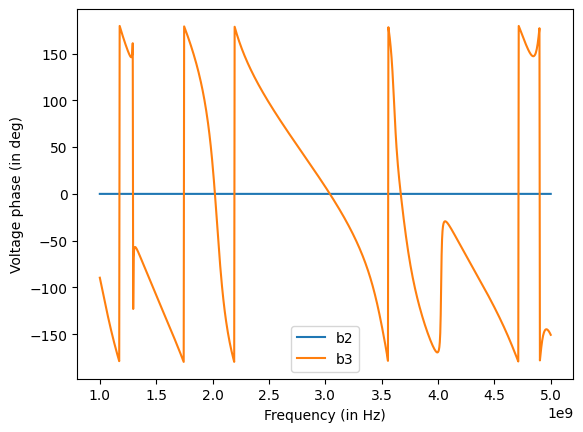

In [87]:
fig, ax = plt.subplots()
plt.plot(freq_rrc, a1, label = 'a1')
plt.plot(freq_rrc, np.abs(b2), label = 'b2')
#plt.plot(freq_rrc, np.abs(b3), label = 'b3')
ax.set_ylabel('Voltage Amplitude (in V)')
ax.set_xlabel('Frequency (in Hz)')
ax.legend(loc='best')

fig, ax = plt.subplots()
plt.plot(freq_rrc, np.degrees(np.angle(b2)), label = 'b2')
plt.plot(freq_rrc, np.degrees(np.angle(b3)), label = 'b3')
ax.set_ylabel('Voltage phase (in deg)')
ax.set_xlabel('Frequency (in Hz)')
ax.legend()

### Add amplifier to the arms 

In [23]:
s21_amp = list(s_extract(which_s='s21', s_matrix_=sparams_amp))

b2_out_amp = []
b3_out_amp = []
b2_out_phase = []
b3_out_phase = []
b2_out = []
b3_out = []

# Multiplying input voltage with S params to get the output voltage
for i in range(len(s21_amp)):
    b2_out_amp.append(np.abs(s21_amp[i]) * b2_amp[i])
    b2_out_phase.append(np.degrees(np.angle(s21_amp[i] * b2[i])))

    b3_out_amp.append(np.abs(s21_amp[i]) * b3_amp[i])
    b3_out_phase.append(np.degrees(np.angle(s21_amp[i] * b3[i])))

b2_out_amp = np.array(b2_out_amp)
b3_out_amp = np.array(b3_out_amp)
b2_out_phase = np.array(b2_out_phase)
b3_out_phase = np.array(b3_out_phase)

b2_out = np.complex128(b2_out_amp * np.exp(1j * b2_out_phase))
b3_out = np.complex128(b3_out_amp * np.exp(1j * b3_out_phase))

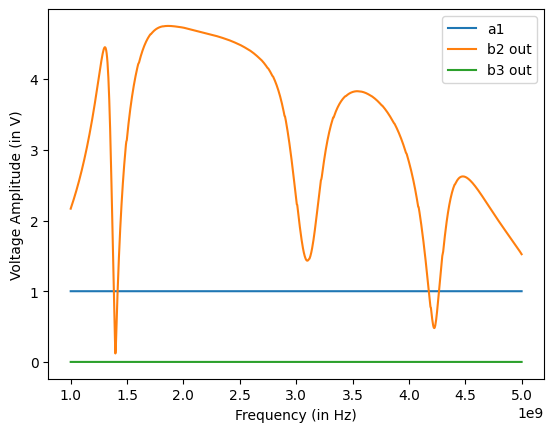

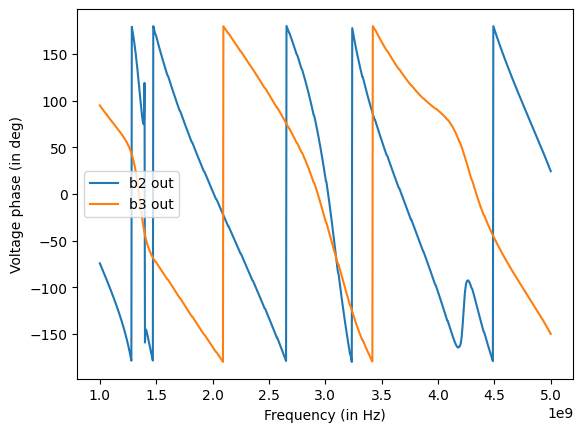

In [24]:
fig, ax = plt.subplots()
plt.plot(freq_rrc, a1, label = 'a1')
plt.plot(freq_rrc, np.abs(b2_out), label = 'b2 out')
plt.plot(freq_rrc, np.abs(b3_out), label = 'b3 out')
ax.set_ylabel('Voltage Amplitude (in V)')
ax.set_xlabel('Frequency (in Hz)')
ax.legend(loc='best')

fig, ax = plt.subplots()
plt.plot(freq_rrc, b2_out_phase, label = 'b2 out')
plt.plot(freq_rrc, b3_out_phase, label = 'b3 out')
ax.set_ylabel('Voltage phase (in deg)')
ax.set_xlabel('Frequency (in Hz)')
ax.legend()

# Correlation computation

C:\Users\gharj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\gharj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


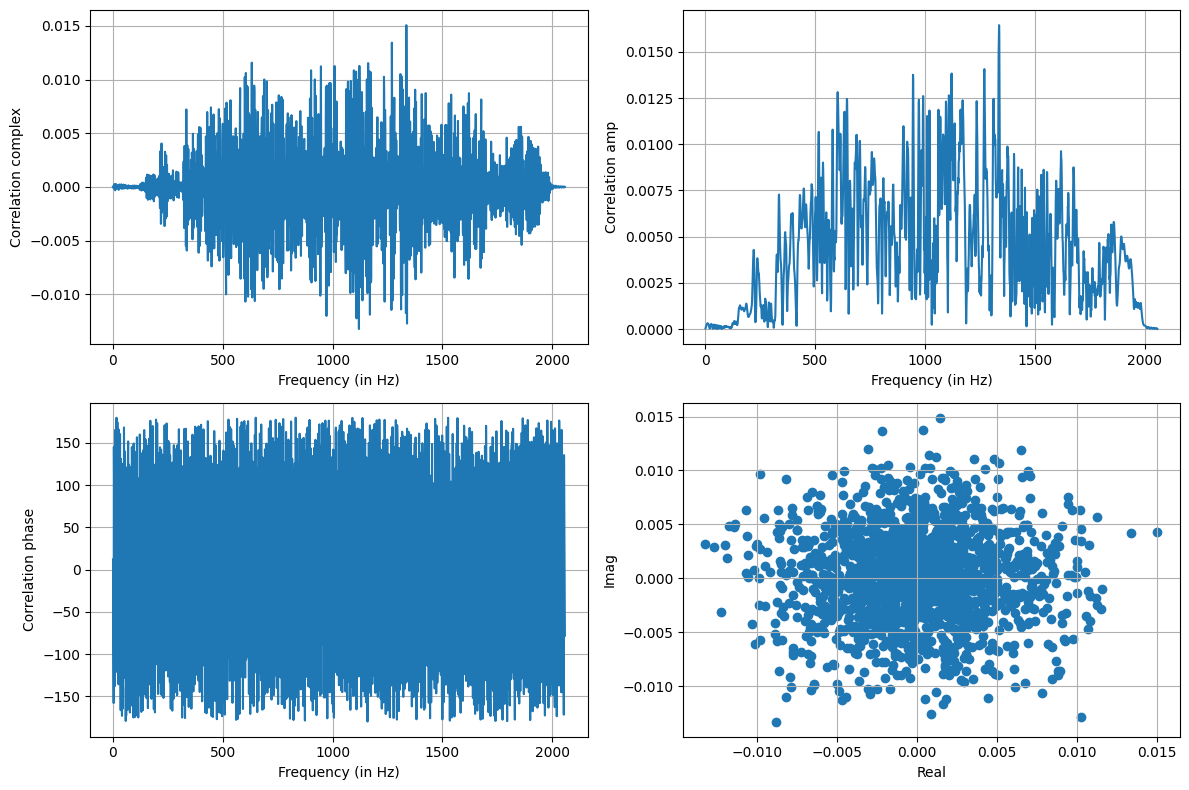

In [25]:
cross_correlation_out = np.correlate(b2_out, b3_out, mode='full')

# Create 2x2 subplots
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(cross_correlation_out, label = 'correlated signal')
plt.ylabel('Correlation complex')
plt.xlabel('Frequency (in Hz)')
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(np.abs(cross_correlation_out), label = ' corr signal amp')
plt.ylabel('Correlation amp')
plt.xlabel('Frequency (in Hz)')
plt.grid()

plt.subplot(2, 2, 3)
plt.plot(np.degrees(np.angle(cross_correlation_out)), label = 'corr signal phase')
plt.ylabel('Correlation phase')
plt.xlabel('Frequency (in Hz)')
plt.legend
plt.grid()

plt.subplot(2, 2, 4)
plt.scatter(np.real(cross_correlation_out), np.imag(cross_correlation_out))
plt.xlabel('Real')
plt.ylabel('Imag')
plt.grid()

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

# Archived

In [ ]:
#on state data from datasheet
switch_params_df_on = {}

switch_params_df_on["freq"] = [1.0,1.5,2.0,2.5, 3.0, 3.5, 4.0,4.5,5.0]
switch_params_df_on["s11"] = [-46.063921148409776,-46.063921148409776,-40.08642747565284,-36.607495663871006,-32.2556771343947,-29.417446108853213,-27.318075533434577,-27.318075533434577,-26.444385894678376]
switch_params_df_on["s21"] = [-0.04, -0.05, -0.06, -0.07, -0.07, -0.08, -0.08, -0.09, -0.09]
switch_params_df_on["s31"] = [-100.96, -87.38, -97.34, -104.72, -102.92, -99.72, -93.03, -99.42, -90.70]
switch_params_df_on["s41"] = [-120, -120, -120, -120, -120, -120, -120, -120, -120]

switch_params_df_on["s12"] = [-0.04, -0.05, -0.06, -0.07, -0.07, -0.08, -0.08, -0.09, -0.09]
switch_params_df_on["s22"] = [-46.063921148409776,-46.063921148409776,-40.08642747565284,-36.607495663871006,-32.2556771343947,-29.417446108853213,-27.318075533434577,-27.318075533434577,-26.444385894678376]
switch_params_df_on["s32"] = [-120, -120, -120, -120, -120, -120, -120, -120, -120]
switch_params_df_on["s42"] = [-100.96, -87.38, -97.34, -104.72, -102.92, -99.72, -93.03, -99.42, -90.70]

switch_params_df_on["s13"] = [-100.96, -87.38, -97.34, -104.72, -102.92, -99.72, -93.03, -99.42, -90.70]
switch_params_df_on["s23"] = [-120, -120, -120, -120, -120, -120, -120, -120, -120]
switch_params_df_on["s33"] = [-46.063921148409776,-46.063921148409776,-40.08642747565284,-36.607495663871006,-32.2556771343947,-29.417446108853213,-27.318075533434577,-27.318075533434577,-26.444385894678376]
switch_params_df_on["s43"] = [-0.04, -0.05, -0.06, -0.07, -0.07, -0.08, -0.08, -0.09, -0.09]

switch_params_df_on["s14"] = [-120, -120, -120, -120, -120, -120, -120, -120, -120]
switch_params_df_on["s24"] = [-100.96,-87.38,  -97.34,  -104.72, -102.92,-99.72, -93.03, -99.42, -90.70]
switch_params_df_on["s34"] = [-0.04,  -0.05,   -0.06,   -0.07,   -0.07,  -0.08,  -0.08,  -0.09,  -0.09]
switch_params_df_on["s44"] = [-46.063921148409776,-46.063921148409776,-40.08642747565284,-36.607495663871006,-32.2556771343947,-29.417446108853213,-27.318075533434577,-27.318075533434577,-26.444385894678376]

sparams_switch_s4p = interpolate_smatrix_datasheet(params_df_ori=switch_params_df_on,original_indices=switch_params_df_on["freq"], db_true=True, req_length=1030, port=4, lim=[1e9,5e9])
#s_plotter(which_s='s11,s21,s31,s41', plot_db=True, freq_=freq_rrc_s4p, freq_unit='GHz', s_matrix_=sparams_switch_s4p, bw_cutline=None)